# Setup
Loading all the necessary libraries.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
#import tabulate

from statsmodels.sandbox.stats.runs import runstest_1samp
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.stattools import acf

import qda

import os
import re
from scipy import ndimage
import math
import random
import cv2
import skimage
from scipy import stats
import pylab

from PIL import Image, ImageEnhance
from skimage.measure import label, regionprops
from skimage.io import imsave
from skimage.filters import threshold_otsu

from sklearn.decomposition import PCA

In [2]:
n_objects = 80

# Helper functions
Here we define the functions that we later use in the proceeding of the notebook.  
You can find here the `img_info_to_part_id` and `rotate_and_crop` functions cited in the report. 

In [3]:
def img_info_to_part_id(imgname, location):
	imgid = int(re.search(r"img(\d+)\.bmp", imgname).group(1))
	if location == "top_left":
		return (imgid - 1) * 4
	elif location == "bottom_left":
		return (imgid - 1) * 4 + 1
	elif location == "top_right":
		return (imgid - 1) * 4 + 2
	elif location == "bottom_right":
		return (imgid - 1) * 4 + 3
	else:
		raise ValueError("Invalid location: {}".format(location))

# example
print(img_info_to_part_id("img01.bmp", "top_left"))
print(img_info_to_part_id("img01.bmp", "bottom_left"))
print(img_info_to_part_id("img01.bmp", "top_right"))
print(img_info_to_part_id("img01.bmp", "bottom_right"))
print()
print(img_info_to_part_id("img02.bmp", "top_left"))
print(img_info_to_part_id("img02.bmp", "bottom_left"))
print(img_info_to_part_id("img02.bmp", "top_right"))
print(img_info_to_part_id("img02.bmp", "bottom_right"))

def part_id_to_img_info(part_id):
	pid_copy = part_id
	while pid_copy % 4 != 0:
		pid_copy -= 1
	imgnum = pid_copy // 4 +1 
	imgnum = "{:02d}".format(imgnum)

	if part_id % 4 == 0:
		location = "top_left"
	elif part_id % 4 == 1:
		location = "bottom_left"
	elif part_id % 4 == 2:
		location = "top_right"
	elif part_id % 4 == 3:
		location = "bottom_right"
	else:
		raise ValueError("Invalid part ID: {}".format(part_id))

	return imgnum, location

# example
print(part_id_to_img_info(0))
print(part_id_to_img_info(1))
print(part_id_to_img_info(2))
print(part_id_to_img_info(3))
print()
print(part_id_to_img_info(4))
print(part_id_to_img_info(5))
print(part_id_to_img_info(6))
print(part_id_to_img_info(7))

cartella_immagini = {
	'originals': './Processed dataset/df old/',
	'rot&crop': './Processed dataset/df new/',
	# other possible folders
}

# in english: generate_image_path
def genera_percorso_immagine(part_id, which_ones="originals",option="seg"):	
	imgnum, location = part_id_to_img_info(part_id)
	real_option = option
	if option=="seg":
		real_option = "segmented"
	else:
		real_option = "labeled"

	nome_immagine = f"img{imgnum}.bmp_{location}_{real_option}.png"
	return os.path.join(cartella_immagini[which_ones], nome_immagine)

# Utilizzo della funzione
print(genera_percorso_immagine(0, "originals"))
print(genera_percorso_immagine(1, "originals"))
print(genera_percorso_immagine(2, "originals"))
print(genera_percorso_immagine(3, "originals"))

0
1
2
3

4
5
6
7
('01', 'top_left')
('01', 'bottom_left')
('01', 'top_right')
('01', 'bottom_right')

('02', 'top_left')
('02', 'bottom_left')
('02', 'top_right')
('02', 'bottom_right')
./Processed dataset/df old/img01.bmp_top_left_segmented.png
./Processed dataset/df old/img01.bmp_bottom_left_segmented.png
./Processed dataset/df old/img01.bmp_top_right_segmented.png
./Processed dataset/df old/img01.bmp_bottom_right_segmented.png


In [4]:
def visualize_object(part_id):
	# plt.figure(figsize=(8, 10))
	# plt.figure(figsize=(10, 4))
	plt.figure(figsize=(8, 3))

	plt.subplot(1,2,1)
	img_new = plt.imread(genera_percorso_immagine(part_id, "rot&crop","lab"))
	height, width = img_new.shape[:2]
	# print("height, width:", height, width)
	zoom_factor = 0.8 
	zoomed_width = width * zoom_factor
	zoomed_height = height * zoom_factor
	x_center = width // 2
	y_center = height // 2
	x1 = max(0, x_center - zoomed_width // 2)
	x2 = min(width, x_center + zoomed_width // 2)
	y1 = max(0, y_center - zoomed_height // 2)
	y2 = min(height, y_center + zoomed_height // 2)
	plt.imshow(img_new, cmap="gray")
	plt.axis('off')
	plt.xlim(x1, x2)
	plt.ylim(y2, y1)
	plt.title(f"img new (part_id {part_id}, nvoids={df_new_parts.iloc[part_id]['Num_voids']})")

	plt.subplot(1, 2, 2)
	# plt.subplot(1, 4, 4)
	img_new = plt.imread(genera_percorso_immagine(part_id, "rot&crop","seg"))
	# print("height, width:", img_new.shape[:2])
	plt.imshow(img_new,cmap="gray")
	plt.title(f"img new (part_id {part_id}, nvoids={df_new_parts.iloc[part_id]['Num_voids']})")
	plt.axis("off")

	plt.tight_layout()
	plt.show()

In [5]:
def rotate_and_crop(img, rect, verbose=0):
	# get params
	center, size, angle = rect[0], rect[1], rect[2]
	
	if angle > 45:
		angle = angle - 90
	if verbose == 1:
		print(f"Angle inside function is {angle}")
	
	center, size = tuple(map(int, center)), tuple(map(int, size))
	if verbose==1:
		print(rect)
		print(center)
		print(size)
	# get row and col num in img
	height, width = img.shape[0], img.shape[1]
	# rotation matrix
	M = cv2.getRotationMatrix2D(center, angle, 1)
	# apply rotation
	img_rot = cv2.warpAffine(img, M, (width, height))
	# crop it
	img_crop = cv2.getRectSubPix(img_rot, size, center)

	return img_crop, img_rot

def calculate_curvature(points):
	# Calcola la differenza delle coordinate x e y tra i punti successivi e precedenti
	dx = np.gradient(points[:, 0])
	dy = np.gradient(points[:, 1])

	# Calcola la seconda differenza delle coordinate x e y
	d2x = np.gradient(dx)
	d2y = np.gradient(dy)

	# Calcola la curvatura utilizzando la formula di curvatura
	curvature = (d2x * dy - d2y * dx) / (dx**2 + dy**2)**1.5

	return curvature

def summary_assumptions(data_points,titolo="",plotto=0):
	if plotto==1:
		plt.figure(figsize=(12,4))
		plt.subplot(1, 3, 1)
		stats.probplot(data_points,plot=plt)
		plt.subplot(1, 3, 2)
		plt.hist(data_points)
		plt.subplot(1, 3, 3)
		plt.plot(data_points,'o-')
		plt.suptitle(f"{titolo}")
		plt.show()
	_, shapiro_pvalue = stats.shapiro(data_points)
	print(f"({titolo}) Normality p-value = {shapiro_pvalue} - Normality at alpha 5%? {shapiro_pvalue>0.05}")
	_, pval_runs = runstest_1samp(data_points, correction=False)
	print(f'({titolo}) Runs test p-value = {pval_runs} - Random data at alpha 5%? {pval_runs>0.05}')

# Dataset manipulation

In [43]:
# call original python script
%run image_analysis_function.py

## df_new

create it, only needed the first time.

In [11]:
output_folder = "./Processed dataset/df new/"
statistics = []

for part_id in range(0,n_objects):
	img = cv2.imread(genera_percorso_immagine(part_id, "originals"))

	# Converti l'immagine in scala di grigi
	gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
	# Applica il filtro bilaterale per ridurre il rumore
	blurred_img = cv2.bilateralFilter(gray, 10, 100, 100)
	# maybe blurred not really needed
	# decide it in the img input to the next function (choose gray or blurred_img)

	# Applica la binarizzazione Otsu
	(T, threshInv) = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

	# Apply the Canny filter to detect edges
	edged = cv2.Canny(threshInv, 30, 200)

	# Find the contours
	contours, hierarchy = cv2.findContours(edged, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_TC89_KCOS)

	# Select the biggest contour
	largest_contours = sorted(contours, key=cv2.contourArea, reverse=True)[:1]

	# crop the pictures following the biggest contour
	for i, contours in enumerate (largest_contours):
		rect = cv2.minAreaRect(contours)
		box = cv2.boxPoints(rect)
		box = np.int0(box)
		cropped_image, rot_image = rotate_and_crop(img, rect, verbose=0)

		img_info = part_id_to_img_info(part_id)
		filename = f"img{img_info[0]}.bmp_{img_info[1]}_segmented.png"
		cv2.imwrite(os.path.join(output_folder, filename), cropped_image) 

		# print(type(cropped_image))
		# plt.figure(figsize=(12, 12))
		# plt.subplot(1,3,1)
		# plt.imshow(cropped_image)
		# plt.axis('off')
		# plt.title("cropped_image")

		# img_pil = Image.fromarray(cropped_image, 'RGB')
		# img_pil = img_pil.convert('L')
		# print(type(img_pil))
		# plt.imshow(img_pil,cmap="gray")
		# plt.axis('off')
		# plt.show()

		# gray = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2GRAY)
		# (T, threshInv) = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
		# labeled_segmented_image = label(threshInv)
	
		image = Image.open(os.path.join(output_folder, filename))
		# Convert the image to grayscale
		image = image.convert('L')
		# # Increase the contrast
		enhancer = ImageEnhance.Contrast(image)
		image = enhancer.enhance(100)
		# width, height = image.size
		# image = image.crop((0,0,width,height))
		image = np.array(image)
		# plt.imshow(image, cmap='gray')
		# plt.axis('off')  # Nasconde gli assi
		# plt.show()
		otsu_thresh = threshold_otsu(image)
		image = image > otsu_thresh

		# Convert the boolean image to an 8-bit unsigned integer image
		# img = (threshInv.astype(np.uint8) * 255)
		img = (image.astype(np.uint8) * 255)
		# Use regionprops to get properties of the region
		part_props = regionprops(img)[0]  # Get the first (and only) region
		# Crop the image with margin around the bounding box
		minr, minc, maxr, maxc = part_props.bbox
		# print(part_props.bbox)
		minr_crop = max(minr + 12, 0)
		minc_crop = max(minc + 12, 0)
		maxr_crop = min(maxr - 12, img.shape[0])
		maxc_crop = min(maxc - 12, img.shape[1])
		padded_img = img[minr_crop:maxr_crop, minc_crop:maxc_crop]
		
		# Invert the padded image
		inv_padded_img = 255 - padded_img
		# plt.subplot(1,3,2)
		# plt.imshow(inv_padded_img,cmap="gray")
		# plt.axis('off')
		# plt.title("inv_padded_img")

		# Apply labeling
		labels = label(inv_padded_img, background=0)
		# props_voids = regionprops(labels)
		# Find the biggest region
		# biggest_region = max(props_voids, key=lambda region: region.area)
		# Set the pixels in the biggest region to 0
		# labels[labels == biggest_region.label] = 0
		# Repeat labeling
		# labels = label(labels, background=0)
		props_voids = regionprops(labels)
		# Create a figure and axes
		plt.figure(figsize=(8, 8))
		fig, ax = plt.subplots()
		# Display the image
		ax.imshow(labels, cmap='nipy_spectral')
		# Annotate label numbers

		for region in regionprops(labels):
			# Get the coordinates of the centroid
			y, x = region.centroid
			# Annotate the label number at the centroid
			ax.text(x, y, str(region.label), color='white')
		# Save the labeled image  		
		labeled_filename = f"img{img_info[0]}.bmp_{img_info[1]}_labeled.png"
		labeled_output_path = os.path.join(output_folder, labeled_filename)
		plt.savefig(labeled_output_path)
		# Close the figure to free up memory
		# plt.show()
		# plt.close()
		plt.close('all')


		# For each statistic in regionprops, create a row with Image name, Position, Region type, ID, and each metric
		statistics.append({
			"Image name": f"img{img_info[0]}.bmp",
			"Position": img_info[1],
			"Region type": "part",
			"ID": 0,
			"Area [pixels]": round(part_props.area, 3),
			"Perimeter [pixels]": round(part_props.perimeter, 3),
			"Eccentricity": round(part_props.eccentricity, 3),
			"Orientation [radians]": round(part_props.orientation, 3),
			"Solidity": round(part_props.solidity, 3),
			"Extent": round(part_props.extent, 3),
			"Major Axis Length [pixels]": round(part_props.major_axis_length, 3),
			"Minor Axis Length [pixels]": round(part_props.minor_axis_length, 3),
			"Equivalent Diameter [pixels]": round(part_props.equivalent_diameter, 3),
			"Part_ID": part_id,
			"Num_voids": len(props_voids)
		})

		old_size = len(statistics)
		# print(f"Old size: {len(statistics)}")

		# Loop over each void
		for i, prop in enumerate(props_voids, start=1):
			# For each statistic in regionprops, create a row with Image name, Position, Region type, ID, and each metric
			statistics.append({
				"Image name": f"img{img_info[0]}.bmp",
				"Position": img_info[1],
				"Region type": "void",
				"ID": i,
				"Area [pixels]": round(prop.area, 3),
				"Perimeter [pixels]": round(prop.perimeter, 3),
				"Eccentricity": round(prop.eccentricity, 3),
				"Orientation [radians]": round(prop.orientation, 3),
				"Solidity": round(prop.solidity, 3),
				"Extent": round(prop.extent, 3),
				"Major Axis Length [pixels]": round(prop.major_axis_length, 3),
				"Minor Axis Length [pixels]": round(prop.minor_axis_length, 3),
				"Equivalent Diameter [pixels]": round(prop.equivalent_diameter, 3),
				"Part_ID": part_id,
				"Num_voids": len(props_voids)
			})

		# print(f"Nvoids from props: {len(props_voids)}")
		# print(f"Rows added now: {len(statistics)-old_size}")
		# print(f"Nvoids in df old were: {df_old_parts.iloc[part_id]['Num_voids']}\n")
		if (len(statistics)-old_size) != len(props_voids):
			print("Something strange happened")
			break

# Convert the list of dictionaries to a DataFrame
statistics_df = pd.DataFrame(statistics)
# Export the DataFrame to a CSV file in the output_folder
output_file = os.path.join(output_folder, "image_statistics.csv")
statistics_df.to_csv(output_file, index=False)

read it 

In [6]:
df_new = pd.read_csv('./Processed dataset/df new/image_statistics.csv')

# add 'Part_ID' using img_info_to_part_id
df_new['Part_ID'] = df_new.apply(lambda row: img_info_to_part_id(row['Image name'], row['Position']), axis=1)
# add 'Num_voids' using group by
df_new['Num_voids'] = df_new.groupby('Part_ID')['ID'].transform('max')

# parts and voids split
df_new_parts = df_new[df_new['Region type'] == 'part']
df_new_voids = df_new[df_new['Region type'] == 'void']
df_new_parts.reset_index(drop=True, inplace=True)
df_new_voids.reset_index(drop=True, inplace=True)

print(df_new_parts.shape)
df_new.head(10)

(80, 15)


Image name  Position Region type  ID  Area [pixels]  Perimeter [pixels]  \
0  img01.bmp  top_left        part   0          38291            4105.674   
1  img01.bmp  top_left        void   1            104              40.142   
2  img01.bmp  top_left        void   2            106              47.799   
3  img01.bmp  top_left        void   3            263              80.355   
4  img01.bmp  top_left        void   4            211              64.006   
5  img01.bmp  top_left        void   5            159              56.355   
6  img01.bmp  top_left        void   6            211              73.077   
7  img01.bmp  top_left        void   7            339              75.841   
8  img01.bmp  top_left        void   8            361              78.184   
9  img01.bmp  top_left        void   9            329              77.770   

   Eccentricity  Orientation [radians]  Solidity  Extent  \
0         0.153                 -1.268     0.760   0.743   
1         0.752                 -1.556     0.912   0.693   
2         0.935                 -1.335     0.898   0.589   
3         0.939                 -1.307     0.895   0.501   
4         0.884                 -1.478     0.887   0.601   
5         0.874                  0.932     0.888   0.523   
6         0.951                 -1.313     0.847   0.471   
7         0.326                  0.692     0.929   0.589   
8         0.502                  1.001     0.928   0.602   
9         0.718                  0.249     0.901   0.580   

   Major Axis Length [pixels]  Minor Axis Length [pixels]  \
0                     277.925                     274.667   
1                      14.874                       9.809   
2                      20.548                       7.293   
3                      32.887                      11.318   
4                      25.354                      11.839   
5                      21.442                      10.408   
6                      31.267                       9.708   
7                      22.505                      21.278   
8                      24.343                      21.051   
9                      26.044                      18.126   

   Equivalent Diameter [pixels]  Part_ID  Num_voids  
0                       220.802        0         41  
1                        11.507        0         41  
2                        11.617        0         41  
3                        18.299        0         41  
4                        16.391        0         41  
5                        14.228        0         41  
6                        16.391        0         41  
7                        20.776        0         41  
8                        21.439        0         41  
9                        20.467        0         41

40


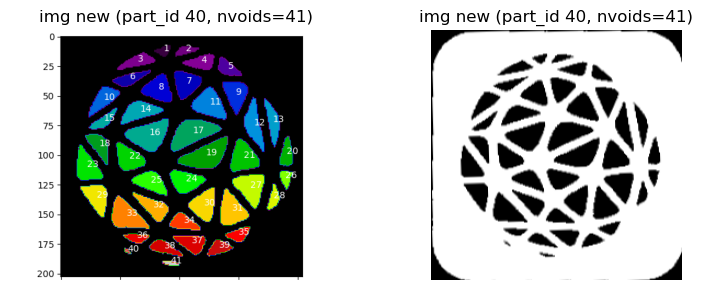

41


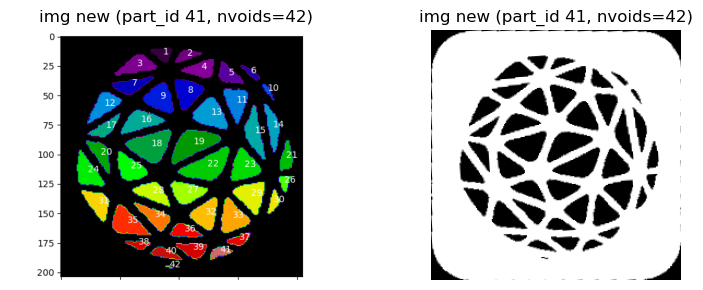

42


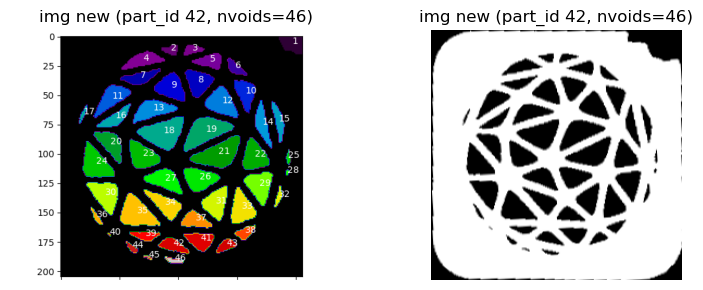

43


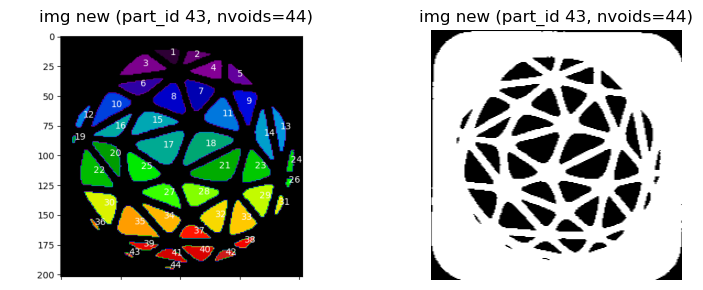

44


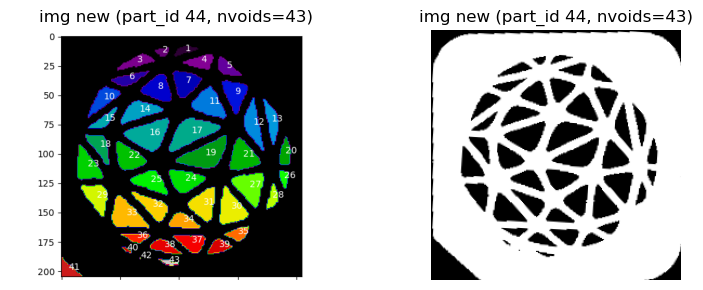

45


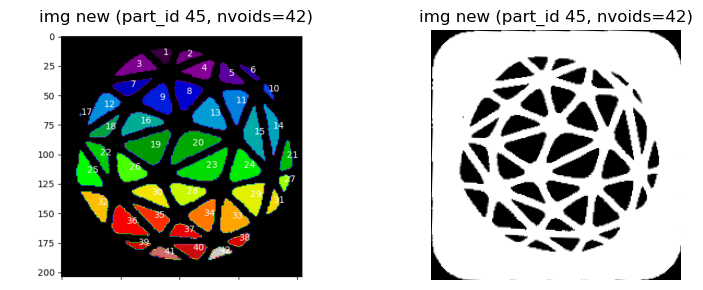

46


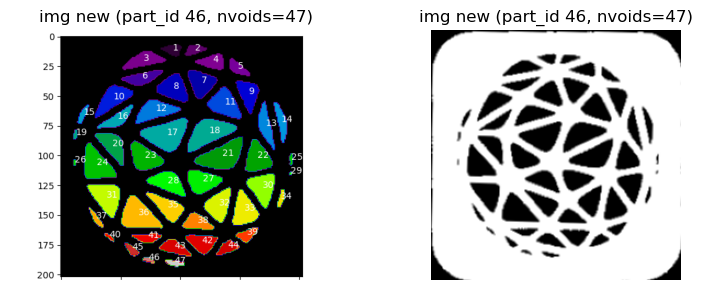

47


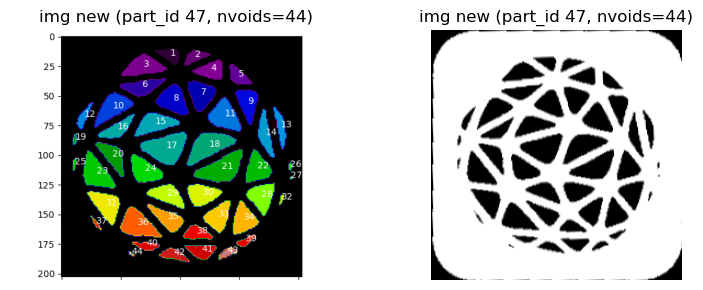

48


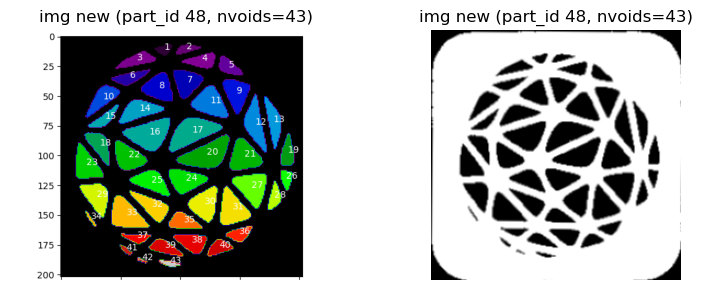

49


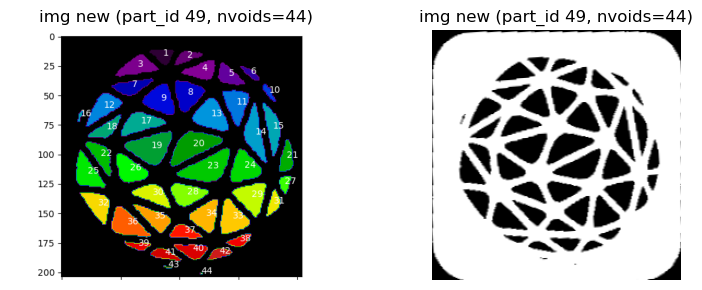

50


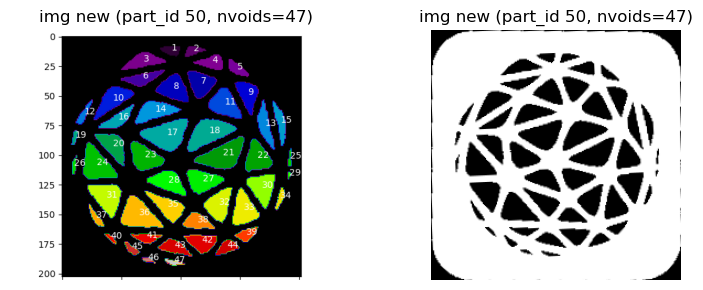

51


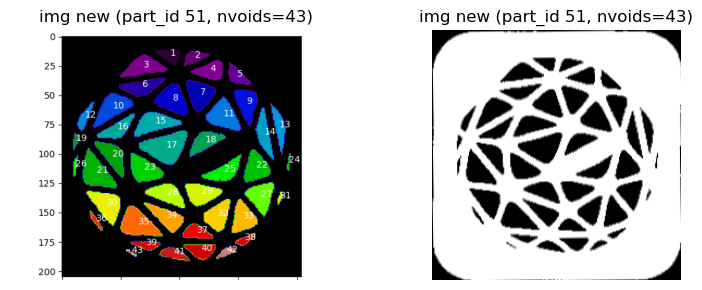

52


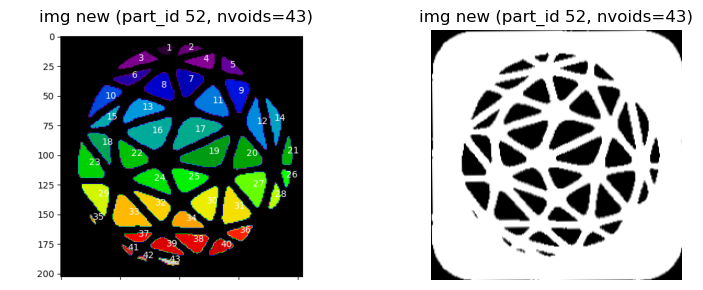

53


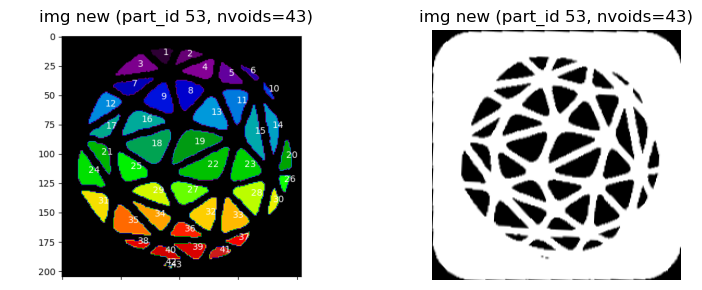

54


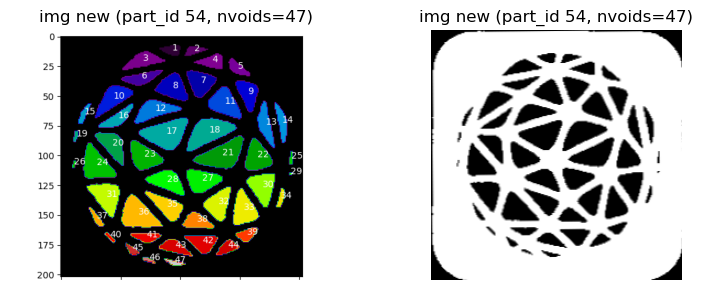

55


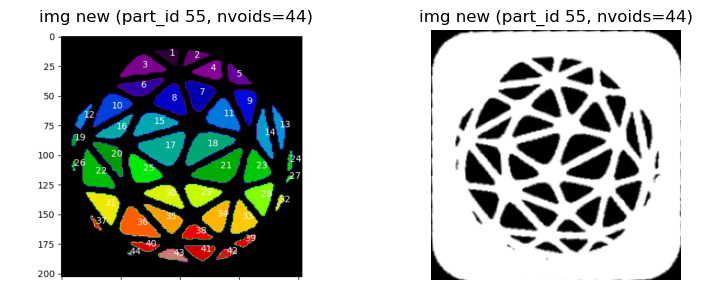

56


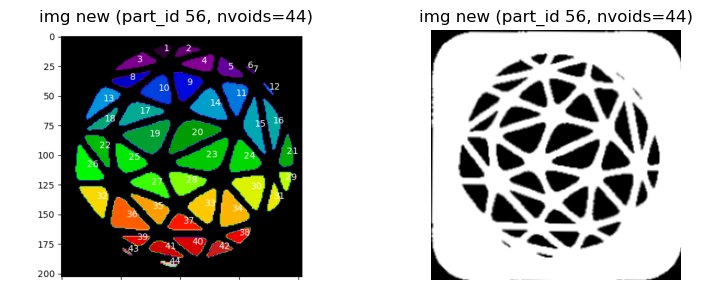

57


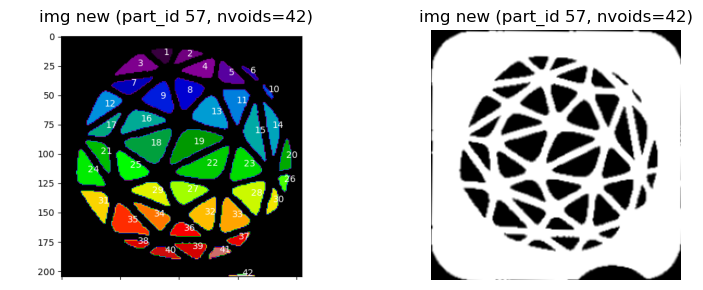

58


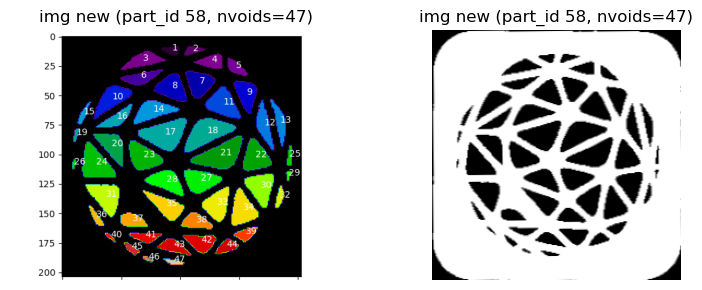

59


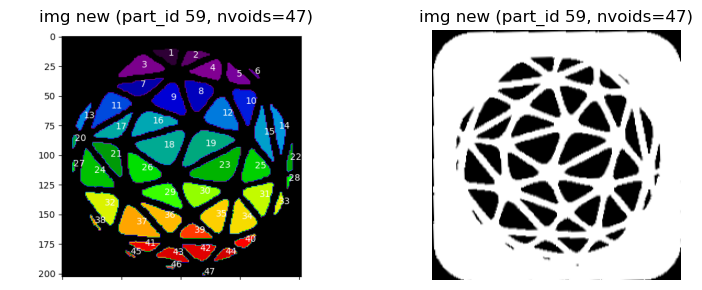

60


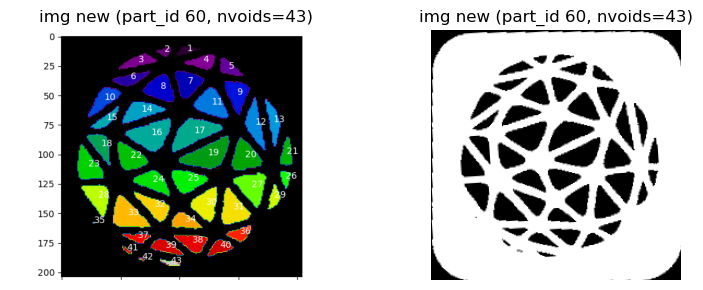

61


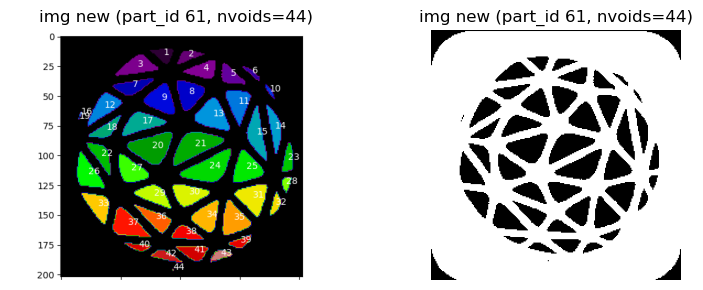

62


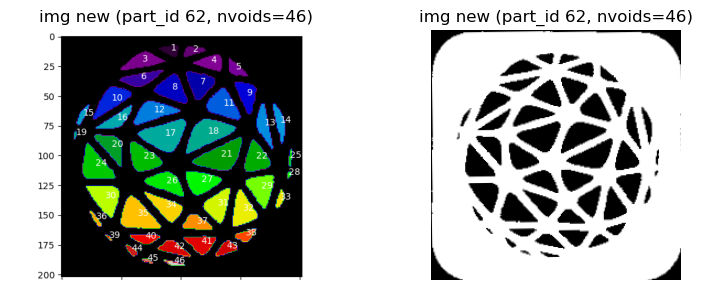

63


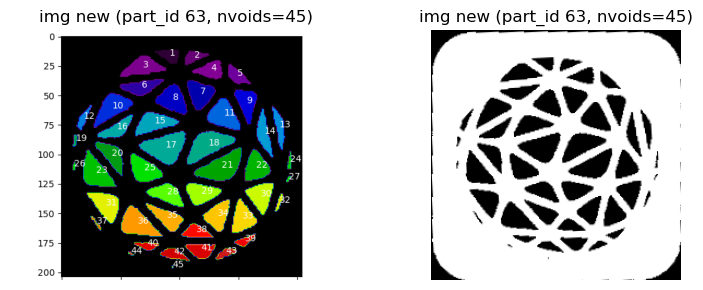

64


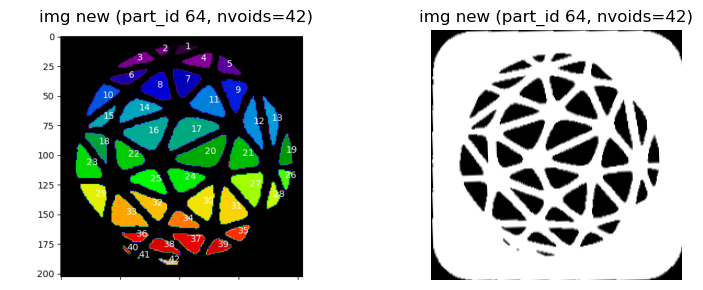

65


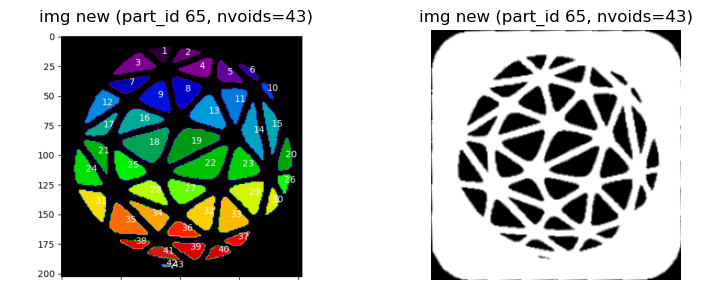

66


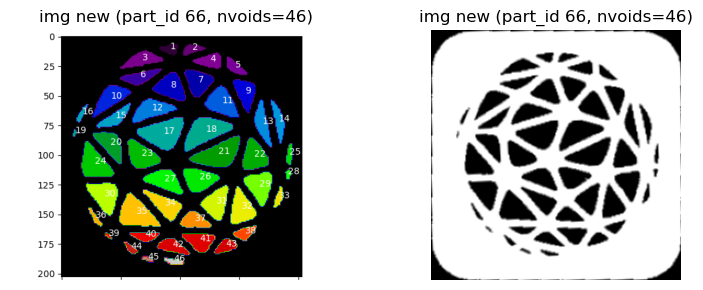

67


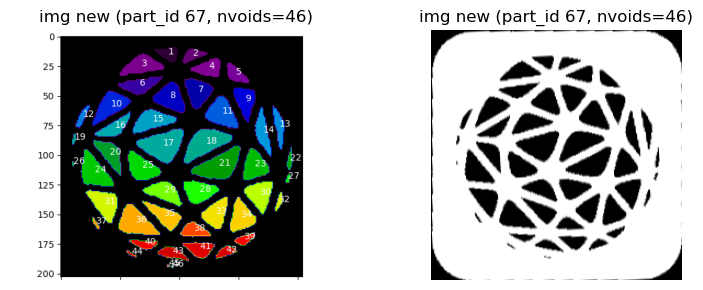

68


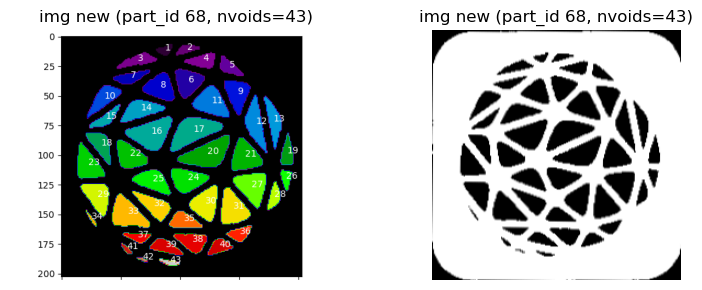

69


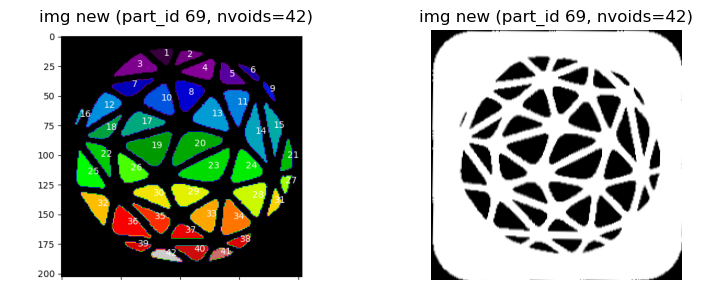

70


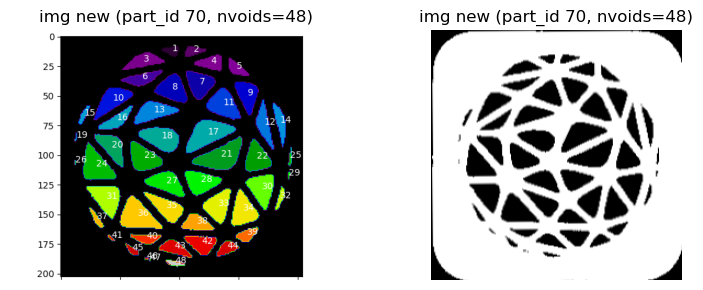

71


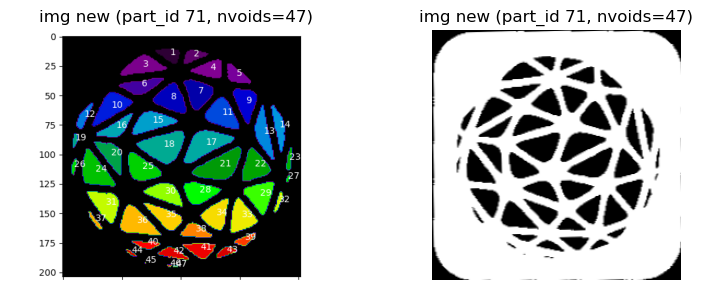

72


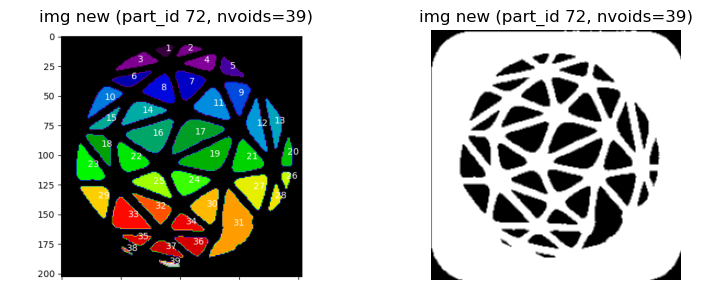

73


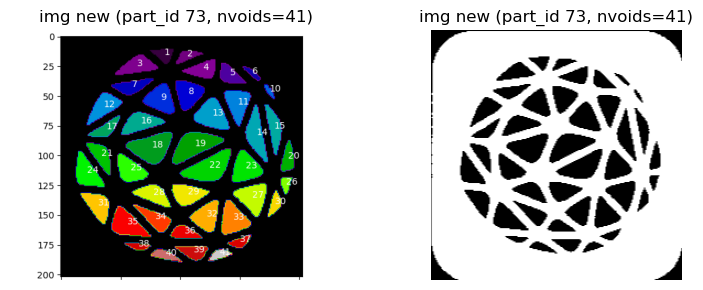

74


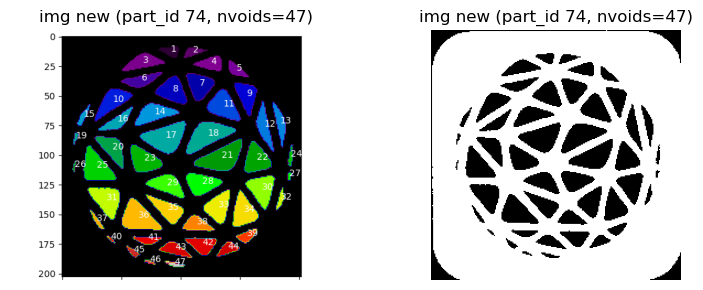

75


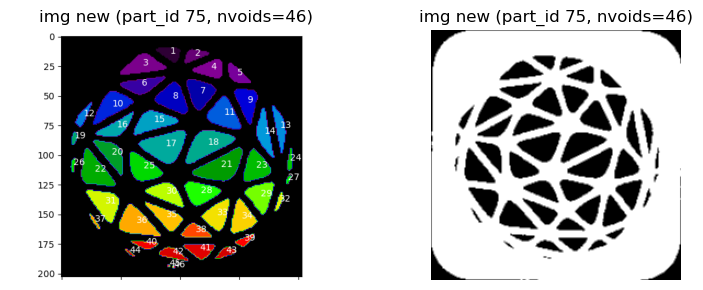

76


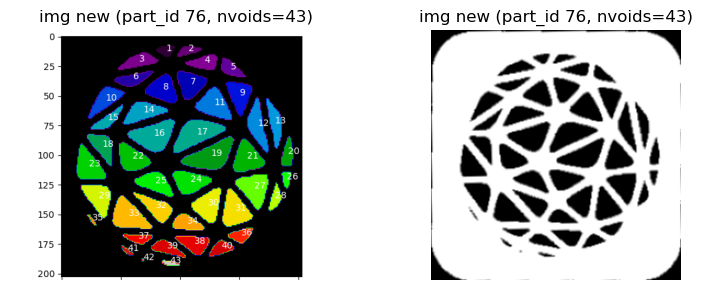

77


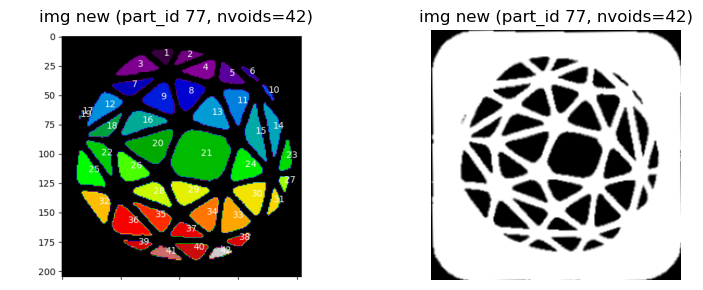

78


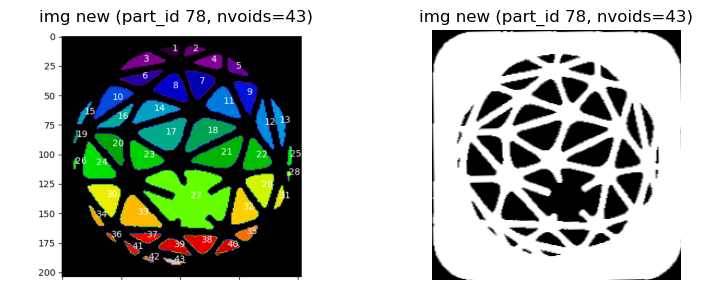

79


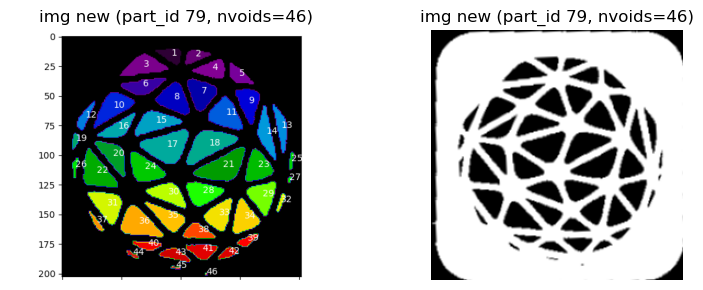

In [97]:
for id in range(40, 80):
    print(id)
    visualize_object(id)

# New variables

## adding curvature

In [7]:
def select_equispaced_points(array, K):
    # Calcola il passo necessario per ottenere K punti
    step = len(array) // K
    
    # Usa arange per creare una lista di indici equispaziati
    indices = np.arange(0, len(array), step)
    
    # Se ci sono più di K indici, prendiamo solo i primi K
    if len(indices) > K:
        indices = indices[:K]
    
    # Seleziona i punti dall'array originale
    selected_points = array[indices]
    
    return selected_points

# Esempio di array
array = np.array([[65, 17],
                  [64, 18],
                  [51, 18],
                  [50, 19],
                  [48, 19],
                  [47, 20],
                  [44, 20],
                  [43, 21],
                  [42, 21],
                  [41, 22]])

# Numero di punti desiderati
K = 3

# Seleziona i punti equispaziati
selected_points = select_equispaced_points(array, K)

print(selected_points)


[[65 17]
 [50 19]
 [44 20]]


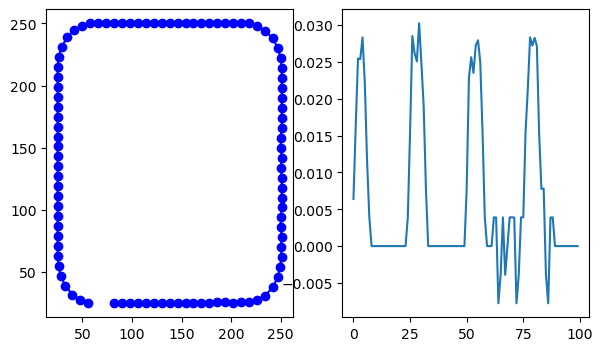

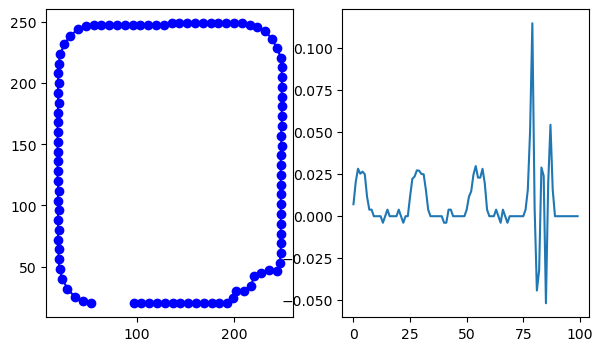

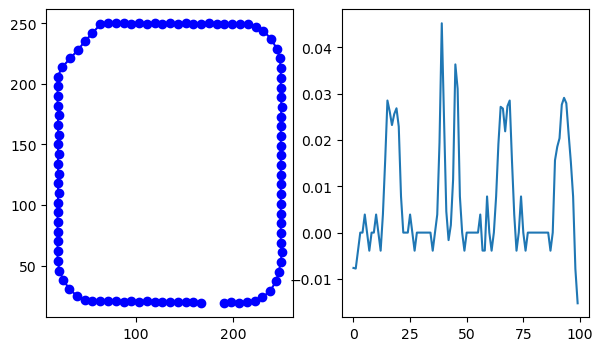

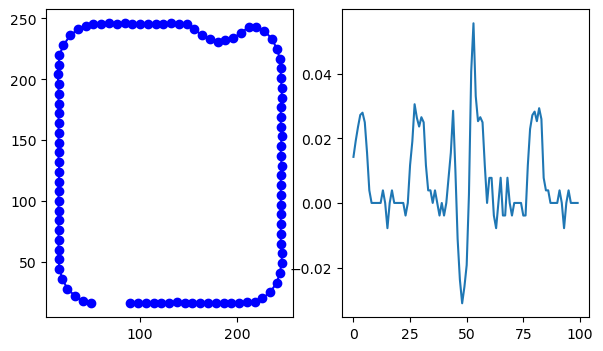

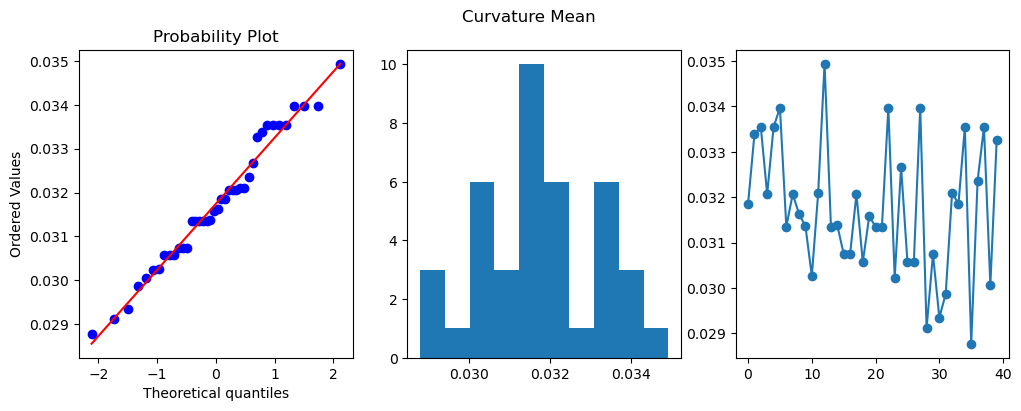

(Curvature Mean) Normality p-value = 0.5104223489761353 - Normality at alpha 5%? True
(Curvature Mean) Runs test p-value = 0.5311101987511753 - Random data at alpha 5%? True


c:\Users\giuli\.conda\envs\qda_environment_v2\lib\site-packages\ipykernel_launcher.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [8]:
# n_objects=40
# n_objects=80 # phase 2

curvatures_mean = np.zeros(n_objects)

for part_id in range(n_objects):

	img = cv2.imread(genera_percorso_immagine(part_id, "originals"))

	# Converti l'immagine in scala di grigi
	gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

	# Applica la binarizzazione Otsu
	(T, threshInv) = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
	# (T, threshInv) = cv2.threshold(blurred_img, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)

	# Apply the Canny filter to detect edges
	edged = cv2.Canny(threshInv, 30, 200)
	# Find the contours
	contours, hierarchy = cv2.findContours(edged, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_TC89_KCOS)

	# Select the biggest contour
	largest_contours = sorted(contours, key=cv2.contourArea, reverse=True)[:1]

	img_with_contours = img.copy()

	# crop the pictures following the biggest contour
	for i, contours in enumerate (largest_contours):
		rect = cv2.minAreaRect(contours)
		box = cv2.boxPoints(rect)
		box = np.int0(box)
		# print(f"Angle here is {rect[2]}")
		cropped_image, rot_image = rotate_and_crop(img, rect, verbose=0)
		# print(f"Angle in df was {df.loc[part_id, 'Orientation [radians]']} radians, ie {math.degrees(df.loc[part_id, 'Orientation [radians]'])} degrees")
		# cropped_images.append(cropped_image)                
		# cropped_filename = os.path.splitext(filename)[0] + "_crp{}.jpg".format(i+1)

		edged = cv2.Canny(rot_image, 30, 200)
		# contours, hierarchy = cv2.findContours(edged, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_TC89_L1)
		# contours, hierarchy = cv2.findContours(edged, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_TC89_KCOS) 
		# maybe better
		contours, hierarchy = cv2.findContours(edged, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_NONE )
		# used officially
		# contours, hierarchy = cv2.findContours(edged, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE )
		largest_contours = sorted(contours, key=cv2.contourArea, reverse=True)[:1]

	# reconnect end with begin points
	contours_points = np.append(largest_contours[0][:, 0], [largest_contours[0][:, 0][0]], axis=0)

	
	selected_points = select_equispaced_points(contours_points, 100)
	# selected_points = contours_points

	x_coords = [point[0] for point in selected_points]
	y_coords = [point[1] for point in selected_points]


	### UPDATE IDEA: compiute the curvature just on a subset of equally spaced points
	# eg if list is long 100, we compute on 7,14,21,28, ecc or similar
	curvature = pd.Series(calculate_curvature(selected_points)).dropna()
	curvature = np.array(curvature)
	# curvature = curvature**1/3

	if part_id==42 or part_id==10 or part_id==44 or part_id==57:
		plt.figure(figsize=(7,4))
		plt.subplot(1, 2, 1)
		plt.plot(x_coords, y_coords, marker='o', linestyle='-', color='b')
		plt.subplot(1, 2,2)
		plt.plot(curvature)
		plt.show()

	# curvatures_mean[part_id] = np.max(np.abs(curvature))+np.mean(curvature)
	
	curvatures_mean[part_id] = np.mean((curvature))
	curvatures_mean[part_id] = np.quantile(curvature,0.95)
	curvatures_mean[part_id] = np.max(curvature)
	# curvatures_mean[part_id] = np.max(np.abs(curvature))

summary_assumptions(curvatures_mean[0:40],"Curvature Mean",plotto=1)
# summary assumption now fails but makes sense, we are on the complete dataset now, 
# not in phase 1
df_new_parts["Curvature Mean"] = curvatures_mean

## adding max void perimeter

In [9]:
biggest_void_perimeter = np.zeros(n_objects)
for pid in range(0,n_objects):
	img_df = df_new_voids.loc[df_new_voids['Part_ID'] == pid]
	biggest_void_perimeter[pid] = np.max(img_df["Perimeter [pixels]"])
	# print(f'biggest void for {pid} was at index {np.argmax(img_df["Area [pixels]"])+1}')

df_new_parts["Max Void Perimeter"] = biggest_void_perimeter

c:\Users\giuli\.conda\envs\qda_environment_v2\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


## adding max void area

In [10]:
biggest_void_areas = np.zeros(n_objects)
for pid in range(0,n_objects):
	img_df = df_new_voids.loc[df_new_voids['Part_ID'] == pid]
	biggest_void_areas[pid] = np.max(img_df["Area [pixels]"])
	# print(f'biggest void for {pid} was at index {np.argmax(img_df["Area [pixels]"])+1}')

df_new_parts["Max Void Area"] = biggest_void_areas

c:\Users\giuli\.conda\envs\qda_environment_v2\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


## experiment for max bar thickness

The maximum thickness of the bars is: 10.0
pid 72
34217.0


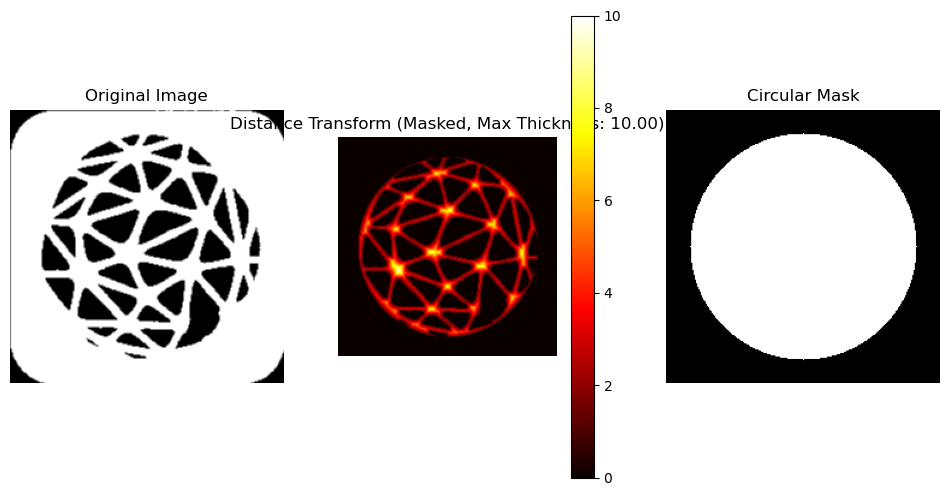

In [11]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Load the image
pid = np.random.randint(0,79)
# pid = 51
# image_path = img_new = plt.imread(genera_percorso_immagine(part_id, "rot&crop","lab"))
image_path = genera_percorso_immagine(pid, "rot&crop","seg")
image = cv2.imread(image_path)

# Converti l'immagine in scala di grigi
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# Applica la binarizzazione Otsu
(T, binary_image) = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

# plt.imshow(binary_image,cmap='gray', vmin=0, vmax=1)
# plt.show()

# Convert to grayscale
# gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# Convert to binary image
# _, binary_image = cv2.threshold(gray_image, 127, 255, cv2.THRESH_BINARY)

# Invert the binary image
# binary_image = cv2.bitwise_not(binary_image)

# plt.imshow(binary_image,cmap='gray', vmin=0, vmax=1)
# plt.show()


# Apply distance transform
dist_transform = cv2.distanceTransform(binary_image, cv2.DIST_L2, cv2.DIST_MASK_5)
# Create a circular mask
h, w = binary_image.shape
center = (w // 2, h // 2)
radius = min(center[0], center[1], w - center[0], h - center[1])-20
mask = np.zeros((h, w), dtype=np.uint8)
cv2.circle(mask, center, radius, 1, thickness=-1)
# Apply the mask to the distance transform
# masked_dist_transform = dist_transform * mask

binary_image = binary_image * mask
masked_dist_transform = cv2.distanceTransform(binary_image, cv2.DIST_C, cv2.DIST_MASK_3)

# Find the maximum thickness
max_thickness = np.max(masked_dist_transform)

# Display the result
print(f"The maximum thickness of the bars is: {max_thickness}")

# Visualize the distance transform and mask
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(masked_dist_transform, cmap='hot')
plt.title(f'Distance Transform (Masked, Max Thickness: {max_thickness:.2f})')
plt.colorbar()
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(mask, cmap='gray')
plt.title('Circular Mask')
plt.axis('off')

print("pid",pid)
print(masked_dist_transform.sum())
plt.show()

## sum area voids

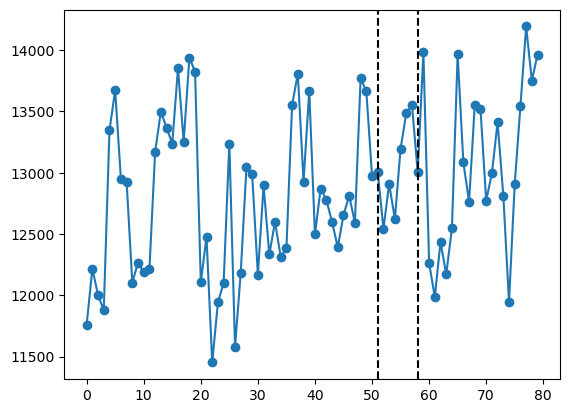

In [139]:
sum_area_voids = np.zeros(n_objects)
for pid in range(0,n_objects):
	img_df = df_new_voids.loc[df_new_voids['Part_ID'] == pid]
	sum_area_voids[pid] = img_df["Area [pixels]"].sum()
	# print(f'biggest void for {pid} was at index {np.argmax(img_df["Area [pixels]"])+1}')

plt.plot(sum_area_voids,'o-')
plt.axvline(x = 51, color = 'k', linestyle='--')
plt.axvline(x = 58, color = 'k', linestyle='--')
# df_new_parts["Max Void Area"] = biggest_void_areas

# Visualizations

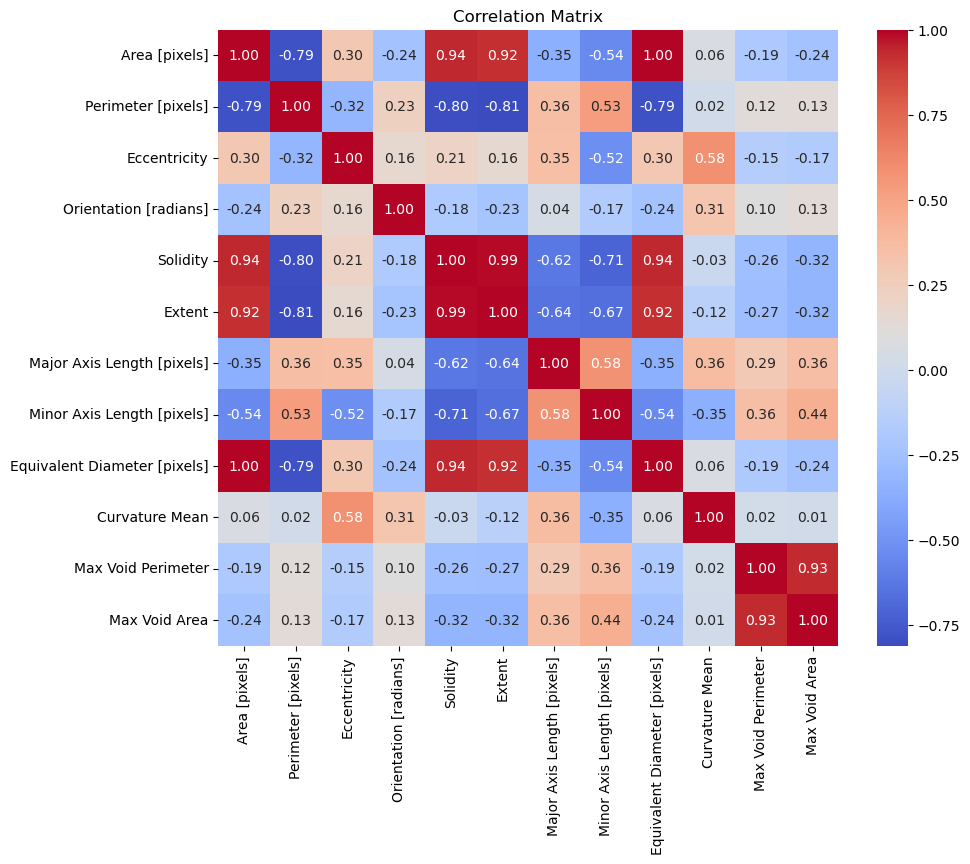

In [14]:
data = df_new_parts.copy()
data = data.drop(columns=["ID","Part_ID","Num_voids"])
cor_matrix = data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(cor_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

## Normality assumption

In [12]:
for col in df_new_parts.columns[4:]:
	summary_assumptions(df_new_parts[col],col,0)
	print("")

(Area [pixels]) Normality p-value = 0.42154160141944885 - Normality at alpha 5%? True
(Area [pixels]) Runs test p-value = 0.04328246701271295 - Random data at alpha 5%? False

(Perimeter [pixels]) Normality p-value = 0.9709747433662415 - Normality at alpha 5%? True
(Perimeter [pixels]) Runs test p-value = 1.9307220920869607e-05 - Random data at alpha 5%? False

(Eccentricity) Normality p-value = 4.3285705032758415e-05 - Normality at alpha 5%? False
(Eccentricity) Runs test p-value = 0.3171712441365728 - Random data at alpha 5%? True

(Orientation [radians]) Normality p-value = 8.18354095599716e-09 - Normality at alpha 5%? False
(Orientation [radians]) Runs test p-value = 0.09803524176915683 - Random data at alpha 5%? True

(Solidity) Normality p-value = 0.20628142356872559 - Normality at alpha 5%? True
(Solidity) Runs test p-value = 2.0082676524039933e-05 - Random data at alpha 5%? False

(Extent) Normality p-value = 0.31123125553131104 - Normality at alpha 5%? True
(Extent) Runs test 

Selection

In [15]:
# Selection
data_part_norm = data.drop(columns=['Orientation [radians]'])  # remove also Num_Wpixels, same info of Area
data_part_norm = data_part_norm.drop(columns=['Solidity','Extent', 'Equivalent Diameter [pixels]'])
dataNum = data_part_norm.select_dtypes(include=np.number)
dataNum.head(10)

Area [pixels]  Perimeter [pixels]  Eccentricity  \
0          38291            4105.674         0.153   
1          37887            4155.306         0.157   
2          37334            4106.076         0.189   
3          37868            4139.319         0.164   
4          36599            4223.005         0.118   
5          36382            4305.088         0.104   
6          36808            4366.544         0.067   
7          36903            4180.034         0.127   
8          37697            4124.720         0.123   
9          37626            4153.833         0.117   

   Major Axis Length [pixels]  Minor Axis Length [pixels]  Curvature Mean  \
0                     277.925                     274.667        0.031852   
1                     279.026                     275.584        0.033381   
2                     277.777                     272.791        0.033541   
3                     277.900                     274.158        0.032066   
4                     280.140                     278.182        0.033541   
5                     280.715                     279.187        0.033967   
6                     278.233                     277.617        0.031352   
7                     279.169                     276.892        0.032066   
8                     277.368                     275.259        0.031632   
9                     277.820                     275.897        0.031359   

   Max Void Perimeter  Max Void Area  
0             114.740          603.0  
1             116.326          633.0  
2             112.326          647.0  
3             114.154          651.0  
4             117.983          672.0  
5             118.569          687.0  
6             115.154          674.0  
7             114.083          681.0  
8             114.326          630.0  
9             114.326          615.0

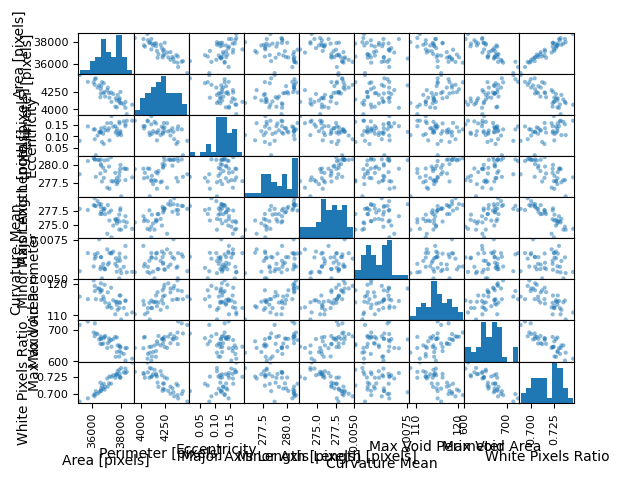

In [21]:
#Scatter plot
dataset=dataNum
pd.plotting.scatter_matrix(dataset)
plt.show()

# can see some linear correlated vars and some very sparse/uncorrelated

## Randomness

In [24]:
for col in df_new_parts.columns[4:]:
   _, pval_runs = runstest_1samp(df_new_parts[col], correction=False)
   print('Runs test p-value for', col ,' = {:.3f}'.format(pval_runs))
   if pval_runs<0.05:
     print('The null hypothesis is rejected: the process is not random')
   else:
     print('The null hypothesis is accepted: the process is random')

Runs test p-value for Area [pixels]  = 0.043
The null hypothesis is rejected: the process is not random
Runs test p-value for Perimeter [pixels]  = 0.000
The null hypothesis is rejected: the process is not random
Runs test p-value for Eccentricity  = 0.317
The null hypothesis is accepted: the process is random
Runs test p-value for Orientation [radians]  = 0.098
The null hypothesis is accepted: the process is random
Runs test p-value for Solidity  = 0.000
The null hypothesis is rejected: the process is not random
Runs test p-value for Extent  = 0.000
The null hypothesis is rejected: the process is not random
Runs test p-value for Major Axis Length [pixels]  = 0.263
The null hypothesis is accepted: the process is random
Runs test p-value for Minor Axis Length [pixels]  = 0.280
The null hypothesis is accepted: the process is random
Runs test p-value for Equivalent Diameter [pixels]  = 0.043
The null hypothesis is rejected: the process is not random
Runs test p-value for Part_ID  = 0.000


# SPCs

First attempts

In [ ]:
## Code to break dataset using trays as samples

#m=10   #number of trays
#n=4    #elements per tray
#data_tray=np.array(data['Area [pixels]']).reshape(m,n)
#data_tray=pd.DataFrame(data_tray)
#data_tray.head()

## Xbar-R control charts
#data_XR = qda.ControlCharts.XbarR(data_tray)



## I-MR-R control chart
## Create a new dataframe that stores the mean of all the samples
#data_Xbar = pd.DataFrame(data_XR['sample_mean'])
#data_Xbar.head()
#data_Xbar = qda.ControlCharts.IMR(data_Xbar, 'sample_mean')
## Plot the R chart as well
#plt.title('R chart')
#plt.plot(data_XR['sample_range'], color='b', linestyle='--', marker='o')
#plt.plot(data_XR['R_UCL'], color='r')
#plt.plot(data_XR['R_CL'], color='g')
#plt.plot(data_XR['R_LCL'], color='r')
#plt.ylabel('Sample range')
#plt.xlabel('Sample number')
## add the values of the control limits on the right side of the plot
#plt.text(len(data_XR)+.5, data_XR['R_UCL'].iloc[0], 'UCL = {:.3f}'.format(data_XR['R_UCL'].iloc[0]), verticalalignment='center')
#plt.text(len(data_XR)+.5, data_XR['R_CL'].iloc[0], 'CL = {:.3f}'.format(data_XR['R_CL'].iloc[0]), verticalalignment='center')
#plt.text(len(data_XR)+.5, data_XR['R_LCL'].iloc[0], 'LCL = {:.3f}'.format(data_XR['R_LCL'].iloc[0]), verticalalignment='center')
## highlight the points that violate the alarm rules
#plt.plot(data_XR['R_TEST1'], linestyle='none', marker='s', color='r', markersize=10)
#plt.show()

#problems with independence

## Idea 1: Under time series assumptions, bulding SPC, SCC and FVC 

### Area

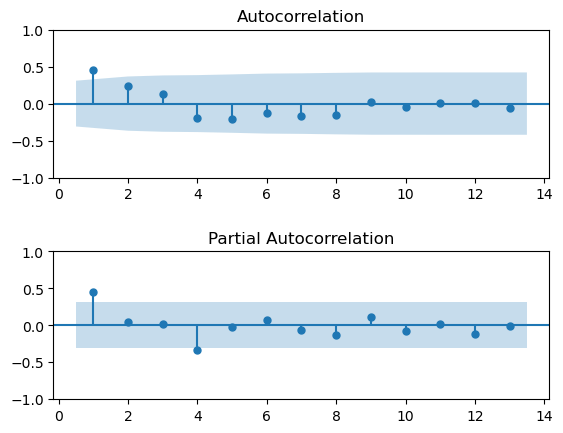

Runs test p-value = 0.025


In [48]:
import statsmodels.graphics.tsaplots as sgt

fig, ax = plt.subplots(2, 1)
sgt.plot_acf(df_new_parts['Area [pixels]'], lags = int(len(df_new_parts)/3), zero=False, ax=ax[0])
fig.subplots_adjust(hspace=0.5)
sgt.plot_pacf(df_new_parts['Area [pixels]'], lags = int(len(df_new_parts)/3), zero=False, ax=ax[1], method = 'ywm')
plt.show()

# Import the necessary libraries for the runs test
from statsmodels.sandbox.stats.runs import runstest_1samp

_, pval_runs = runstest_1samp(df_new_parts['Area [pixels]'], correction=False)
print('Runs test p-value = {:.3f}'.format(pval_runs))

# Not iid --> AR(1) model

In [20]:
df_new_parts['Area_lag1'] = df_new_parts['Area [pixels]'].shift(1)

# Fit the linear regression model
import statsmodels.api as sm

x = df_new_parts['Area_lag1'][1:]
x = sm.add_constant(x)
y = df_new_parts['Area [pixels]'][1:]
model = sm.OLS(y, x).fit()
qda.summary(model)

REGRESSION EQUATION
-------------------
Area [pixels] =  + 19717.318 const + 0.469 Area_lag1

COEFFICIENTS
------------
     Term       Coef   SE Coef  T-Value  P-Value
    const 19717.3183 5367.5324   3.6734   0.0008
Area_lag1     0.4686    0.1442   3.2492   0.0025

MODEL SUMMARY
-------------
       S  R-sq  R-sq(adj)
712.1326 0.222      0.201

ANALYSIS OF VARIANCE
---------------------
    Source   DF     Adj SS     Adj MS  F-Value  P-Value
Regression  1.0 5.3540e+06 5.3540e+06  10.5575   0.0025
     const  1.0 6.8433e+06 6.8433e+06  13.4942   0.0008
 Area_lag1  1.0 5.3540e+06 5.3540e+06  10.5575   0.0025
     Error 37.0 1.8764e+07 5.0713e+05      NaN      NaN
     Total 38.0 2.4118e+07        NaN      NaN      NaN


c:\Users\feder\anaconda3\envs\qda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


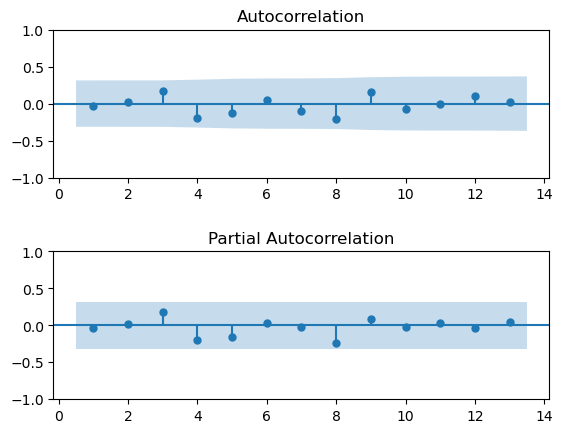

Runs test p-value = 0.254


In [50]:
# Check the autocorrelation of the residuals
fig, ax = plt.subplots(2, 1)
sgt.plot_acf(model.resid, lags = int(len(df_new_parts)/3), zero=False, ax=ax[0])
fig.subplots_adjust(hspace=0.5)
sgt.plot_pacf(model.resid, lags = int(len(df_new_parts)/3), zero=False, ax=ax[1], method = 'ywm')
plt.show()

_, pval_runs_resid = runstest_1samp(model.resid, correction=False)
print('Runs test p-value = {:.3f}'.format(pval_runs_resid))


Shapiro-Wilk test p-value on the residuals = 0.496


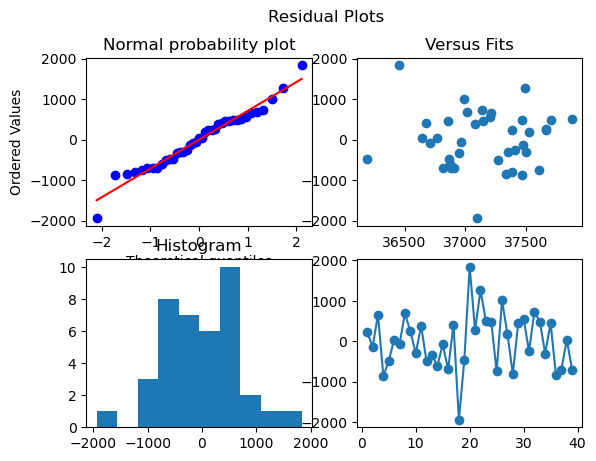

In [51]:
# Plot the residuals and test for normality
fig, axs = plt.subplots(2, 2)
fig.suptitle('Residual Plots')
stats.probplot(model.resid, dist="norm", plot=axs[0,0])
axs[0,0].set_title('Normal probability plot')
axs[0,1].scatter(model.fittedvalues, model.resid)
axs[0,1].set_title('Versus Fits')
axs[1,0].hist(model.resid)
axs[1,0].set_title('Histogram')
axs[1,1].plot(np.arange(1, len(model.resid)+1), model.resid, 'o-')
_, pval_SW_res = stats.shapiro(model.resid)
print('Shapiro-Wilk test p-value on the residuals = %.3f' % pval_SW_res)

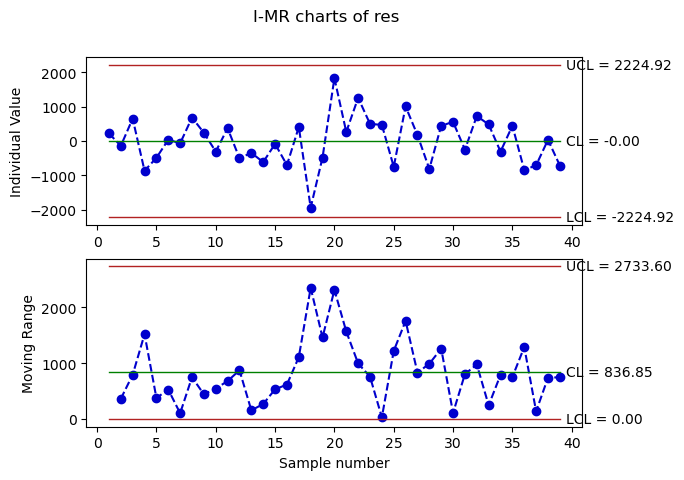

In [52]:
# SCC
# Put the residuals in a dataframe
df_SCC = pd.DataFrame(model.resid, columns=['res'])

# Plot the IMR control chart
df_SCC_IMR = qda.ControlCharts.IMR(df_SCC, 'res')

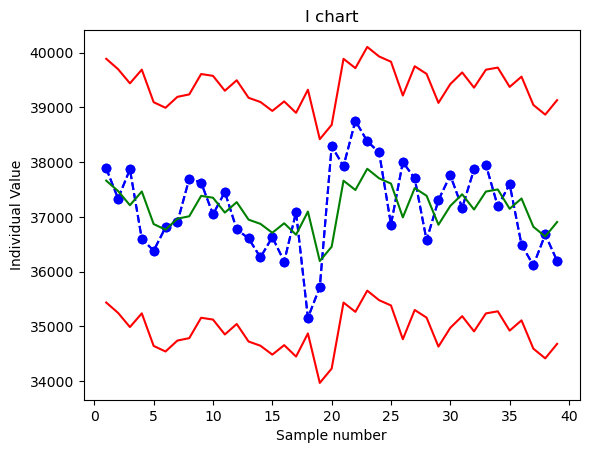

In [53]:
# FVC
d2 = qda.constants.getd2(2)

MRbar_res = df_SCC_IMR['MR_CL'].iloc[0]

# Create a new dataframe with the original data and the center line (the fitted values)
df = pd.DataFrame({'I': df_new_parts['Area [pixels]'].iloc[1:], 'I_CL': model.fittedvalues}, index=df_new_parts.index[1:])

# Add the I_UCL and I_LCL columns with the upper and 
# lower control limits computed from the formula
df['I_UCL'] = df['I_CL'] + 3 * MRbar_res / d2
df['I_LCL'] = df['I_CL'] - 3 * MRbar_res / d2

# Add the TEST1 column
df['I_TEST1'] = np.where((df['I'] > df['I_UCL']) | (df['I'] < df['I_LCL']), df['I'], np.nan)

# Plot the I chart
plt.title('I chart')
plt.plot(df['I'], color='b', linestyle='--', marker='o')
plt.plot(df['I'], color='b', linestyle='--', marker='o')
plt.plot(df['I_UCL'], color='r')
plt.plot(df['I_CL'], color='g')
plt.plot(df['I_LCL'], color='r')
plt.ylabel('Individual Value')
plt.xlabel('Sample number')
# highlight the points that violate the alarm rules
plt.plot(df['I_TEST1'], linestyle='none', marker='s', 
        color='r', markersize=10)

plt.show()

### Perimeter [pixels]

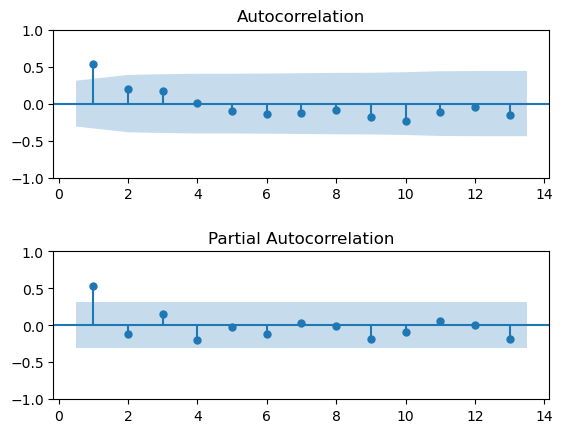

Runs test p-value = 0.026


In [54]:
# Plot the acf and pacf using the statsmodels library
import statsmodels.graphics.tsaplots as sgt

fig, ax = plt.subplots(2, 1)
sgt.plot_acf(df_new_parts['Perimeter [pixels]'], lags = int(len(df_new_parts)/3), zero=False, ax=ax[0])
fig.subplots_adjust(hspace=0.5)
sgt.plot_pacf(df_new_parts['Perimeter [pixels]'], lags = int(len(df_new_parts)/3), zero=False, ax=ax[1], method = 'ywm')
plt.show()

# Import the necessary libraries for the runs test
from statsmodels.sandbox.stats.runs import runstest_1samp

_, pval_runs = runstest_1samp(df_new_parts['Perimeter [pixels]'], correction=False)
print('Runs test p-value = {:.3f}'.format(pval_runs))

# Not iid

In [55]:
df_new_parts['Per_lag1'] = df_new_parts['Perimeter [pixels]'].shift(1)

# Fit the linear regression model
import statsmodels.api as sm

x = df_new_parts['Per_lag1'][1:]
x = sm.add_constant(x)
y = df_new_parts['Perimeter [pixels]'][1:]
model = sm.OLS(y, x).fit()
qda.summary(model)

REGRESSION EQUATION
-------------------
Perimeter [pixels] =  + 1808.237 const + 0.572 Per_lag1

COEFFICIENTS
------------
    Term      Coef  SE Coef  T-Value  P-Value
   const 1808.2371 589.5691   3.0670   0.0040
Per_lag1    0.5723   0.1400   4.0881   0.0002

MODEL SUMMARY
-------------
      S   R-sq  R-sq(adj)
109.531 0.3111     0.2925

ANALYSIS OF VARIANCE
---------------------
    Source   DF      Adj SS      Adj MS  F-Value  P-Value
Regression  1.0 200497.4740 200497.4740  16.7123   0.0002
     const  1.0 112853.5153 112853.5153   9.4068   0.0040
  Per_lag1  1.0 200497.4740 200497.4740  16.7123   0.0002
     Error 37.0 443890.1803  11997.0319      NaN      NaN
     Total 38.0 644387.6543         NaN      NaN      NaN


c:\Users\giuli\.conda\envs\qda_environment_v2\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


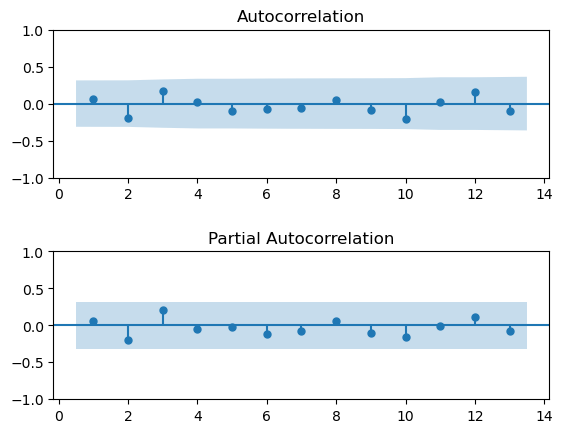

Runs test p-value = 0.436


In [56]:
fig, ax = plt.subplots(2, 1)
sgt.plot_acf(model.resid, lags = int(len(df_new_parts)/3), zero=False, ax=ax[0])
fig.subplots_adjust(hspace=0.5)
sgt.plot_pacf(model.resid, lags = int(len(df_new_parts)/3), zero=False, ax=ax[1], method = 'ywm')
plt.show()

_, pval_runs_resid = runstest_1samp(model.resid, correction=False)
print('Runs test p-value = {:.3f}'.format(pval_runs_resid))

Shapiro-Wilk test p-value on the residuals = 0.685


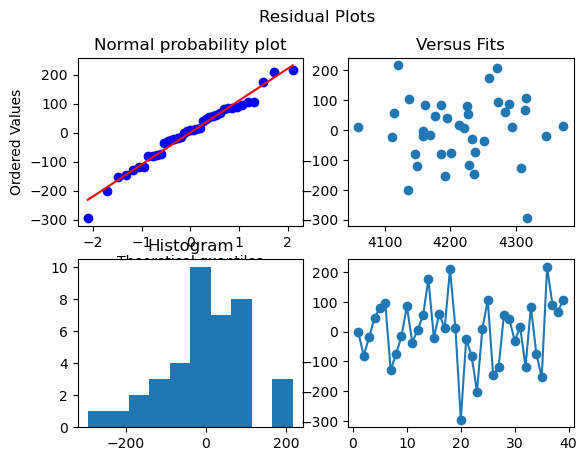

In [57]:
# Plot the residuals and test for normality
fig, axs = plt.subplots(2, 2)
fig.suptitle('Residual Plots')
stats.probplot(model.resid, dist="norm", plot=axs[0,0])
axs[0,0].set_title('Normal probability plot')
axs[0,1].scatter(model.fittedvalues, model.resid)
axs[0,1].set_title('Versus Fits')
axs[1,0].hist(model.resid)
axs[1,0].set_title('Histogram')
axs[1,1].plot(np.arange(1, len(model.resid)+1), model.resid, 'o-')
_, pval_SW_res = stats.shapiro(model.resid)
print('Shapiro-Wilk test p-value on the residuals = %.3f' % pval_SW_res)

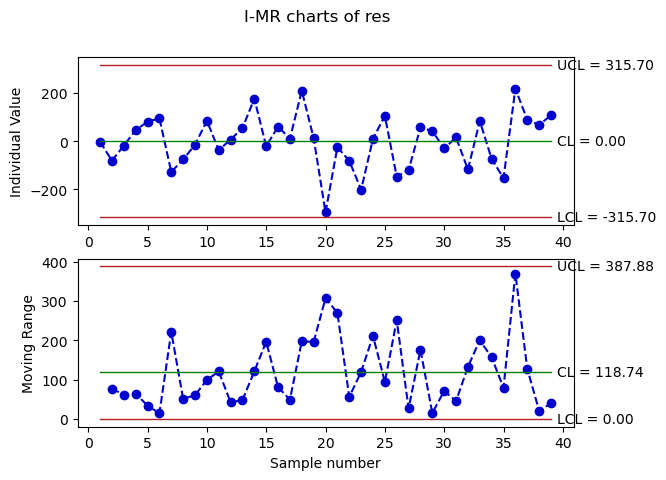

In [58]:
# SCC
# Put the residuals in a dataframe
df_SCC = pd.DataFrame(model.resid, columns=['res'])

# Plot the IMR control chart
df_SCC_IMR = qda.ControlCharts.IMR(df_SCC, 'res')

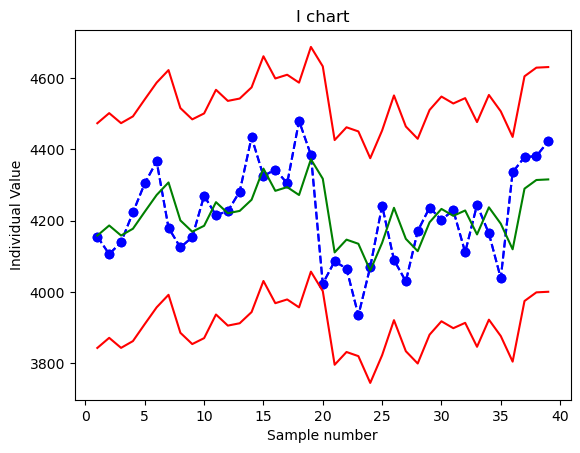

In [59]:
# FVC
d2 = qda.constants.getd2(2)

MRbar_res = df_SCC_IMR['MR_CL'].iloc[0]

# Create a new dataframe with the original data and the center line (the fitted values)
df = pd.DataFrame({'I': df_new_parts['Perimeter [pixels]'].iloc[1:], 'I_CL': model.fittedvalues}, index=df_new_parts.index[1:])

# Add the I_UCL and I_LCL columns with the upper and 
# lower control limits computed from the formula
df['I_UCL'] = df['I_CL'] + 3 * MRbar_res / d2
df['I_LCL'] = df['I_CL'] - 3 * MRbar_res / d2

# Add the TEST1 column
df['I_TEST1'] = np.where((df['I'] > df['I_UCL']) | (df['I'] < df['I_LCL']), df['I'], np.nan)

# Plot the I chart
plt.title('I chart')
plt.plot(df['I'], color='b', linestyle='--', marker='o')
plt.plot(df['I'], color='b', linestyle='--', marker='o')
plt.plot(df['I_UCL'], color='r')
plt.plot(df['I_CL'], color='g')
plt.plot(df['I_LCL'], color='r')
plt.ylabel('Individual Value')
plt.xlabel('Sample number')
# highlight the points that violate the alarm rules
plt.plot(df['I_TEST1'], linestyle='none', marker='s', 
        color='r', markersize=10)

plt.show()

### Major Axis Length [pixels]

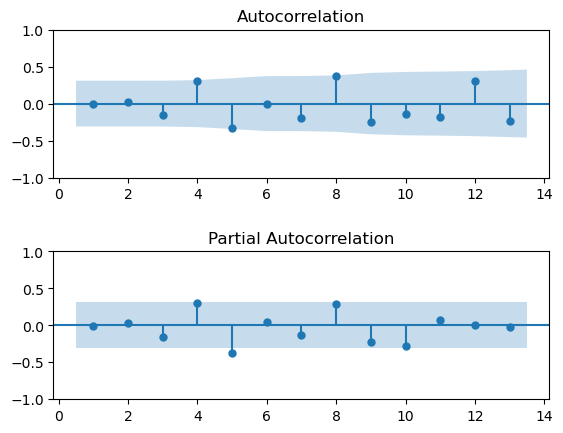

Runs test p-value = 0.749


In [60]:
# Plot the acf and pacf using the statsmodels library
import statsmodels.graphics.tsaplots as sgt

fig, ax = plt.subplots(2, 1)
sgt.plot_acf(df_new_parts['Major Axis Length [pixels]'], lags = int(len(df_new_parts)/3), zero=False, ax=ax[0])
fig.subplots_adjust(hspace=0.5)
sgt.plot_pacf(df_new_parts['Major Axis Length [pixels]'], lags = int(len(df_new_parts)/3), zero=False, ax=ax[1], method = 'ywm')
plt.show()

# Import the necessary libraries for the runs test
from statsmodels.sandbox.stats.runs import runstest_1samp

_, pval_runs = runstest_1samp(df_new_parts['Major Axis Length [pixels]'], correction=False)
print('Runs test p-value = {:.3f}'.format(pval_runs))


# The assumptions are satisfied --> SPC

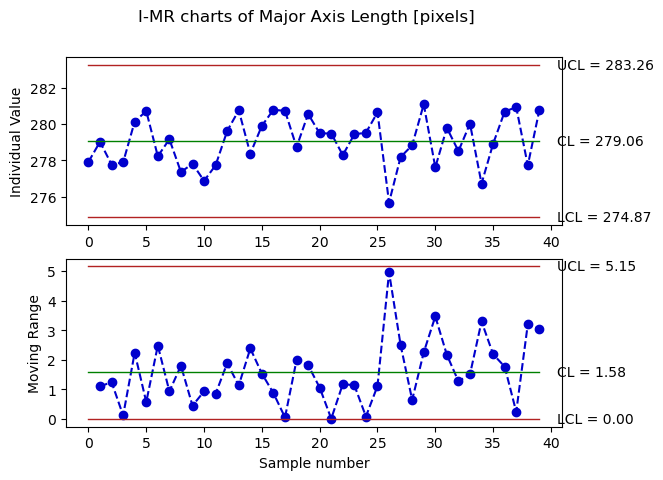

In [61]:
data_IMR = qda.ControlCharts.IMR(df_new_parts, 'Major Axis Length [pixels]')

### Curvature Mean

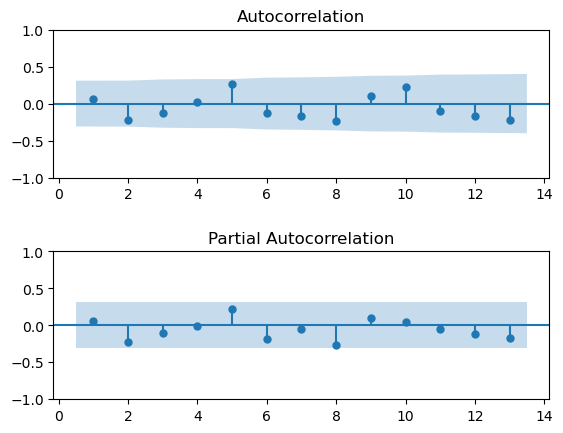

Runs test p-value = 0.522


In [62]:
# Plot the acf and pacf using the statsmodels library
import statsmodels.graphics.tsaplots as sgt

fig, ax = plt.subplots(2, 1)
sgt.plot_acf(df_new_parts['Curvature Mean'], lags = int(len(df_new_parts)/3), zero=False, ax=ax[0])
fig.subplots_adjust(hspace=0.5)
sgt.plot_pacf(df_new_parts['Curvature Mean'], lags = int(len(df_new_parts)/3), zero=False, ax=ax[1], method = 'ywm')
plt.show()

# Import the necessary libraries for the runs test
from statsmodels.sandbox.stats.runs import runstest_1samp

_, pval_runs = runstest_1samp(df_new_parts['Curvature Mean'], correction=False)
print('Runs test p-value = {:.3f}'.format(pval_runs))

# The assumptions are satisfied --> SPC

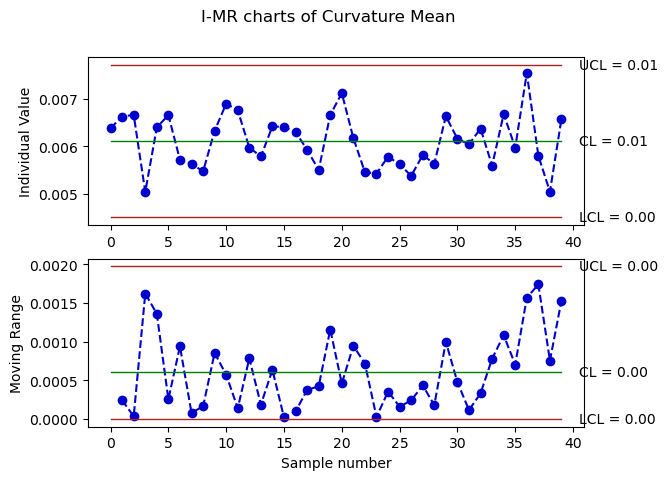

In [63]:
data_IMR = qda.ControlCharts.IMR(df_new_parts, 'Curvature Mean')

### Max Void Perimeter

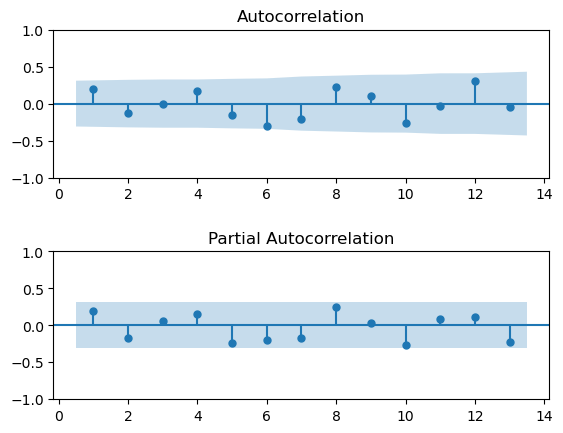

Runs test p-value = 0.161


In [64]:
# Plot the acf and pacf using the statsmodels library
import statsmodels.graphics.tsaplots as sgt

fig, ax = plt.subplots(2, 1)
sgt.plot_acf(df_new_parts['Max Void Perimeter'], lags = int(len(df_new_parts)/3), zero=False, ax=ax[0])
fig.subplots_adjust(hspace=0.5)
sgt.plot_pacf(df_new_parts['Max Void Perimeter'], lags = int(len(df_new_parts)/3), zero=False, ax=ax[1], method = 'ywm')
plt.show()

# Import the necessary libraries for the runs test
from statsmodels.sandbox.stats.runs import runstest_1samp

_, pval_runs = runstest_1samp(df_new_parts['Max Void Perimeter'], correction=False)
print('Runs test p-value = {:.3f}'.format(pval_runs))

# The assumptions are not satisfied


In [ ]:
data_IMR = qda.ControlCharts.IMR(df_new_parts, 'Max Void Perimeter')

### Max Void Area

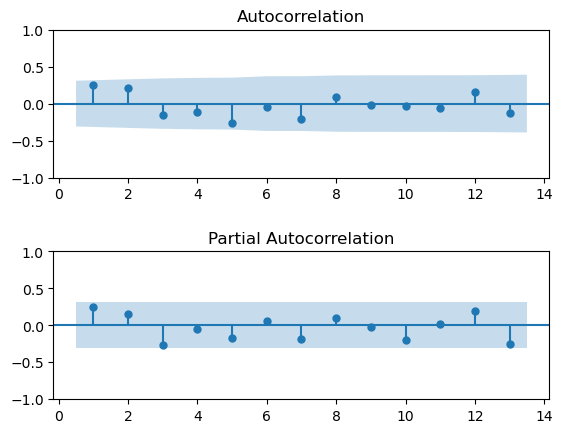

Runs test p-value = 0.749


In [66]:
# Plot the acf and pacf using the statsmodels library
import statsmodels.graphics.tsaplots as sgt

fig, ax = plt.subplots(2, 1)
sgt.plot_acf(df_new_parts['Max Void Area'], lags = int(len(df_new_parts)/3), zero=False, ax=ax[0])
fig.subplots_adjust(hspace=0.5)
sgt.plot_pacf(df_new_parts['Max Void Area'], lags = int(len(df_new_parts)/3), zero=False, ax=ax[1], method = 'ywm')
plt.show()

# Import the necessary libraries for the runs test
from statsmodels.sandbox.stats.runs import runstest_1samp

_, pval_runs = runstest_1samp(df_new_parts['Max Void Area'], correction=False)
print('Runs test p-value = {:.3f}'.format(pval_runs))

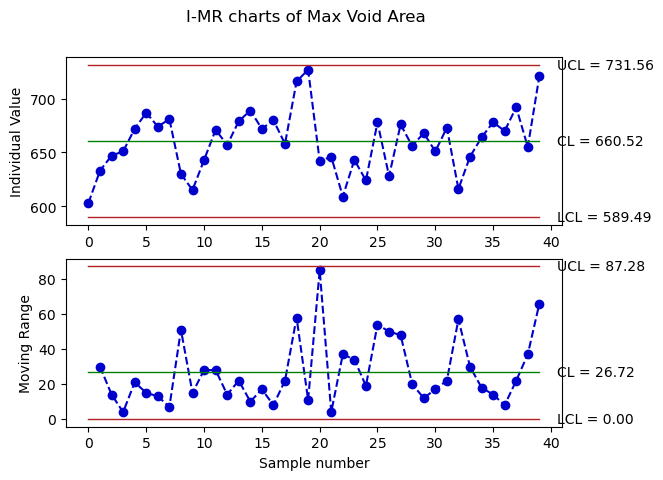

In [67]:
data_IMR = qda.ControlCharts.IMR(df_new_parts, 'Max Void Area')

## Idea 2: indipendence through shuffle

In [458]:
df_new_parts.columns

Index(['Image name', 'Position', 'Region type', 'ID', 'Area [pixels]',
       'Perimeter [pixels]', 'Eccentricity', 'Orientation [radians]',
       'Solidity', 'Extent', 'Major Axis Length [pixels]',
       'Minor Axis Length [pixels]', 'Equivalent Diameter [pixels]', 'Part_ID',
       'Num_voids', 'Curvature Mean', 'Max Void Perimeter', 'Max Void Area'],
      dtype='object')

In [459]:
candidate_variables = ["Area [pixels]", "Perimeter [pixels]", "Major Axis Length [pixels]", 'Curvature Mean', 'Max Void Perimeter', 'Max Void Area']
for relvar in candidate_variables:
	summary_assumptions(df_new_parts[relvar],relvar,0)
	print()

(Area [pixels]) Normality p-value = 0.42154160141944885 - Normality at alpha 5%? True
(Area [pixels]) Runs test p-value = 0.04328246701271295 - Random data at alpha 5%? False

(Perimeter [pixels]) Normality p-value = 0.9709747433662415 - Normality at alpha 5%? True
(Perimeter [pixels]) Runs test p-value = 1.9307220920869607e-05 - Random data at alpha 5%? False

(Major Axis Length [pixels]) Normality p-value = 0.04708345606923103 - Normality at alpha 5%? False
(Major Axis Length [pixels]) Runs test p-value = 0.26260242923260857 - Random data at alpha 5%? True

(Curvature Mean) Normality p-value = 3.6316161246349415e-18 - Normality at alpha 5%? False
(Curvature Mean) Runs test p-value = 0.5375169954850384 - Random data at alpha 5%? True

(Max Void Perimeter) Normality p-value = 1.3253247006592526e-18 - Normality at alpha 5%? False
(Max Void Perimeter) Runs test p-value = 0.11467088857401628 - Random data at alpha 5%? True

(Max Void Area) Normality p-value = 4.7660906124386625e-18 - Norm

In [512]:
chosen_variables = [
	"Area [pixels]",
    "Perimeter [pixels]",
	"Major Axis Length [pixels]",
	'Curvature Mean',
	'Max Void Perimeter',
	'Max Void Area']
seed = 99 # to get the same one of the report/phase 1

## phase 1
# df_shuffled = df_new_parts.sample(frac=1,random_state=seed).reset_index(drop=True)

## phase 2
# Dividi il DataFrame in due parti: prime 40 righe e ultime 40 righe
first_40_rows = df_new_parts.iloc[0:40]
last_40_rows = df_new_parts.iloc[40:]

# Fai lo shuffle delle prime 40 righe
shuffled_first_40_rows = first_40_rows.sample(frac=1,random_state=seed).reset_index(drop=True)

# Riunisci le righe shuffle-ate con le ultime 40 righe
df_shuffled = pd.concat([shuffled_first_40_rows, last_40_rows]) #.reset_index(drop=True)

In [513]:
last_40_rows.tail(10)

Image name      Position Region type  ID  Area [pixels]  \
70  img18.bmp     top_right        part   0          37533   
71  img18.bmp  bottom_right        part   0          37205   
72  img19.bmp      top_left        part   0          36962   
73  img19.bmp   bottom_left        part   0          37373   
74  img19.bmp     top_right        part   0          38035   
75  img19.bmp  bottom_right        part   0          37250   
76  img20.bmp      top_left        part   0          36566   
77  img20.bmp   bottom_left        part   0          36601   
78  img20.bmp     top_right        part   0          36445   
79  img20.bmp  bottom_right        part   0          35793   

    Perimeter [pixels]  Eccentricity  Orientation [radians]  Solidity  Extent  \
70            4287.732         0.126                 -1.355     0.743   0.725   
71            4331.485         0.157                 -0.431     0.739   0.722   
72            4155.975         0.148                 -1.017     0.732   0.717   
73            4193.992         0.116                 -0.737     0.743   0.728   
74            4253.431         0.033                 -0.546     0.758   0.741   
75            4252.213         0.140                 -0.681     0.740   0.723   
76            4283.389         0.106                 -0.767     0.726   0.710   
77            4248.538         0.087                 -0.204     0.717   0.701   
78            4310.502         0.080                 -0.191     0.722   0.704   
79            4432.526         0.129                 -0.444     0.716   0.698   

    Major Axis Length [pixels]  Minor Axis Length [pixels]  \
70                     280.064                     277.830   
71                     280.727                     277.249   
72                     282.060                     278.961   
73                     279.551                     277.671   
74                     276.631                     276.484   
75                     280.239                     277.475   
76                     280.718                     279.126   
77                     284.195                     283.109   
78                     281.690                     280.781   
79                     281.256                     278.894   

    Equivalent Diameter [pixels]  Part_ID  Num_voids  Curvature Mean  \
70                       218.606       70         48        0.031352   
71                       217.649       71         47        0.033067   
72                       216.937       72         39        0.030571   
73                       218.139       73         41        0.029522   
74                       220.063       74         47        0.032429   
75                       217.780       75         46        0.030571   
76                       215.771       76         43        0.031359   
77                       215.875       77         42        0.034356   
78                       215.414       78         43        0.033381   
79                       213.478       79         46        0.033967   

    Max Void Perimeter  Max Void Area  
70             114.912          634.0  
71             114.569          688.0  
72             155.231         1055.0  
73             114.326          643.0  
74             111.740          617.0  
75             114.569          686.0  
76             118.569          682.0  
77             157.296         1696.0  
78             336.534         2404.0  
79             118.569          733.0

In [514]:
df_shuffled.tail(10)

Image name      Position Region type  ID  Area [pixels]  \
70  img18.bmp     top_right        part   0          37533   
71  img18.bmp  bottom_right        part   0          37205   
72  img19.bmp      top_left        part   0          36962   
73  img19.bmp   bottom_left        part   0          37373   
74  img19.bmp     top_right        part   0          38035   
75  img19.bmp  bottom_right        part   0          37250   
76  img20.bmp      top_left        part   0          36566   
77  img20.bmp   bottom_left        part   0          36601   
78  img20.bmp     top_right        part   0          36445   
79  img20.bmp  bottom_right        part   0          35793   

    Perimeter [pixels]  Eccentricity  Orientation [radians]  Solidity  Extent  \
70            4287.732         0.126                 -1.355     0.743   0.725   
71            4331.485         0.157                 -0.431     0.739   0.722   
72            4155.975         0.148                 -1.017     0.732   0.717   
73            4193.992         0.116                 -0.737     0.743   0.728   
74            4253.431         0.033                 -0.546     0.758   0.741   
75            4252.213         0.140                 -0.681     0.740   0.723   
76            4283.389         0.106                 -0.767     0.726   0.710   
77            4248.538         0.087                 -0.204     0.717   0.701   
78            4310.502         0.080                 -0.191     0.722   0.704   
79            4432.526         0.129                 -0.444     0.716   0.698   

    Major Axis Length [pixels]  Minor Axis Length [pixels]  \
70                     280.064                     277.830   
71                     280.727                     277.249   
72                     282.060                     278.961   
73                     279.551                     277.671   
74                     276.631                     276.484   
75                     280.239                     277.475   
76                     280.718                     279.126   
77                     284.195                     283.109   
78                     281.690                     280.781   
79                     281.256                     278.894   

    Equivalent Diameter [pixels]  Part_ID  Num_voids  Curvature Mean  \
70                       218.606       70         48        0.031352   
71                       217.649       71         47        0.033067   
72                       216.937       72         39        0.030571   
73                       218.139       73         41        0.029522   
74                       220.063       74         47        0.032429   
75                       217.780       75         46        0.030571   
76                       215.771       76         43        0.031359   
77                       215.875       77         42        0.034356   
78                       215.414       78         43        0.033381   
79                       213.478       79         46        0.033967   

    Max Void Perimeter  Max Void Area  
70             114.912          634.0  
71             114.569          688.0  
72             155.231         1055.0  
73             114.326          643.0  
74             111.740          617.0  
75             114.569          686.0  
76             118.569          682.0  
77             157.296         1696.0  
78             336.534         2404.0  
79             118.569          733.0

In [28]:
# df_new_parts.to_csv("New_dataset.csv")

In [463]:
for chosvar in chosen_variables:
	summary_assumptions(shuffled_first_40_rows[chosvar],chosvar,0)
	print()

(Area [pixels]) Normality p-value = 0.7310476303100586 - Normality at alpha 5%? True
(Area [pixels]) Runs test p-value = 0.7486942029213925 - Random data at alpha 5%? True

(Perimeter [pixels]) Normality p-value = 0.8690754771232605 - Normality at alpha 5%? True
(Perimeter [pixels]) Runs test p-value = 0.7602698494425246 - Random data at alpha 5%? True

(Major Axis Length [pixels]) Normality p-value = 0.09676539897918701 - Normality at alpha 5%? True
(Major Axis Length [pixels]) Runs test p-value = 0.7486942029213925 - Random data at alpha 5%? True

(Curvature Mean) Normality p-value = 0.5104223489761353 - Normality at alpha 5%? True
(Curvature Mean) Runs test p-value = 0.7602698494425246 - Random data at alpha 5%? True

(Max Void Perimeter) Normality p-value = 0.9064947962760925 - Normality at alpha 5%? True
(Max Void Perimeter) Runs test p-value = 0.08235221505280674 - Random data at alpha 5%? True

(Max Void Area) Normality p-value = 0.5666319727897644 - Normality at alpha 5%? True


In [ ]:
# for seed in range(1,100):
# 	df_shuffled = first_40_rows.sample(frac=1,random_state=seed).reset_index(drop=True)
# 	va_bene = True
# 	for chosvar in chosen_variables:
# 		data=pd.DataFrame(df_shuffled[chosvar])
# 		data_IMR = qda.ControlCharts.IMR(data,chosvar,plotit=False);
# 		va_bene = va_bene & data_IMR["I_TEST1"].isna().all() & data_IMR["MR_TEST1"].isna().all()
# 	if va_bene==True:
# 		print(seed)

### With bonferroni correction since multiple charts

In [464]:
# with different alpha/k
n_var=len(chosen_variables)
alpha = 0.0027/n_var
K_alpha = stats.norm.ppf(1-alpha/2)

print(n_var)
print(K_alpha)

6
3.5088787519844318


In [465]:
OOC_idx = []

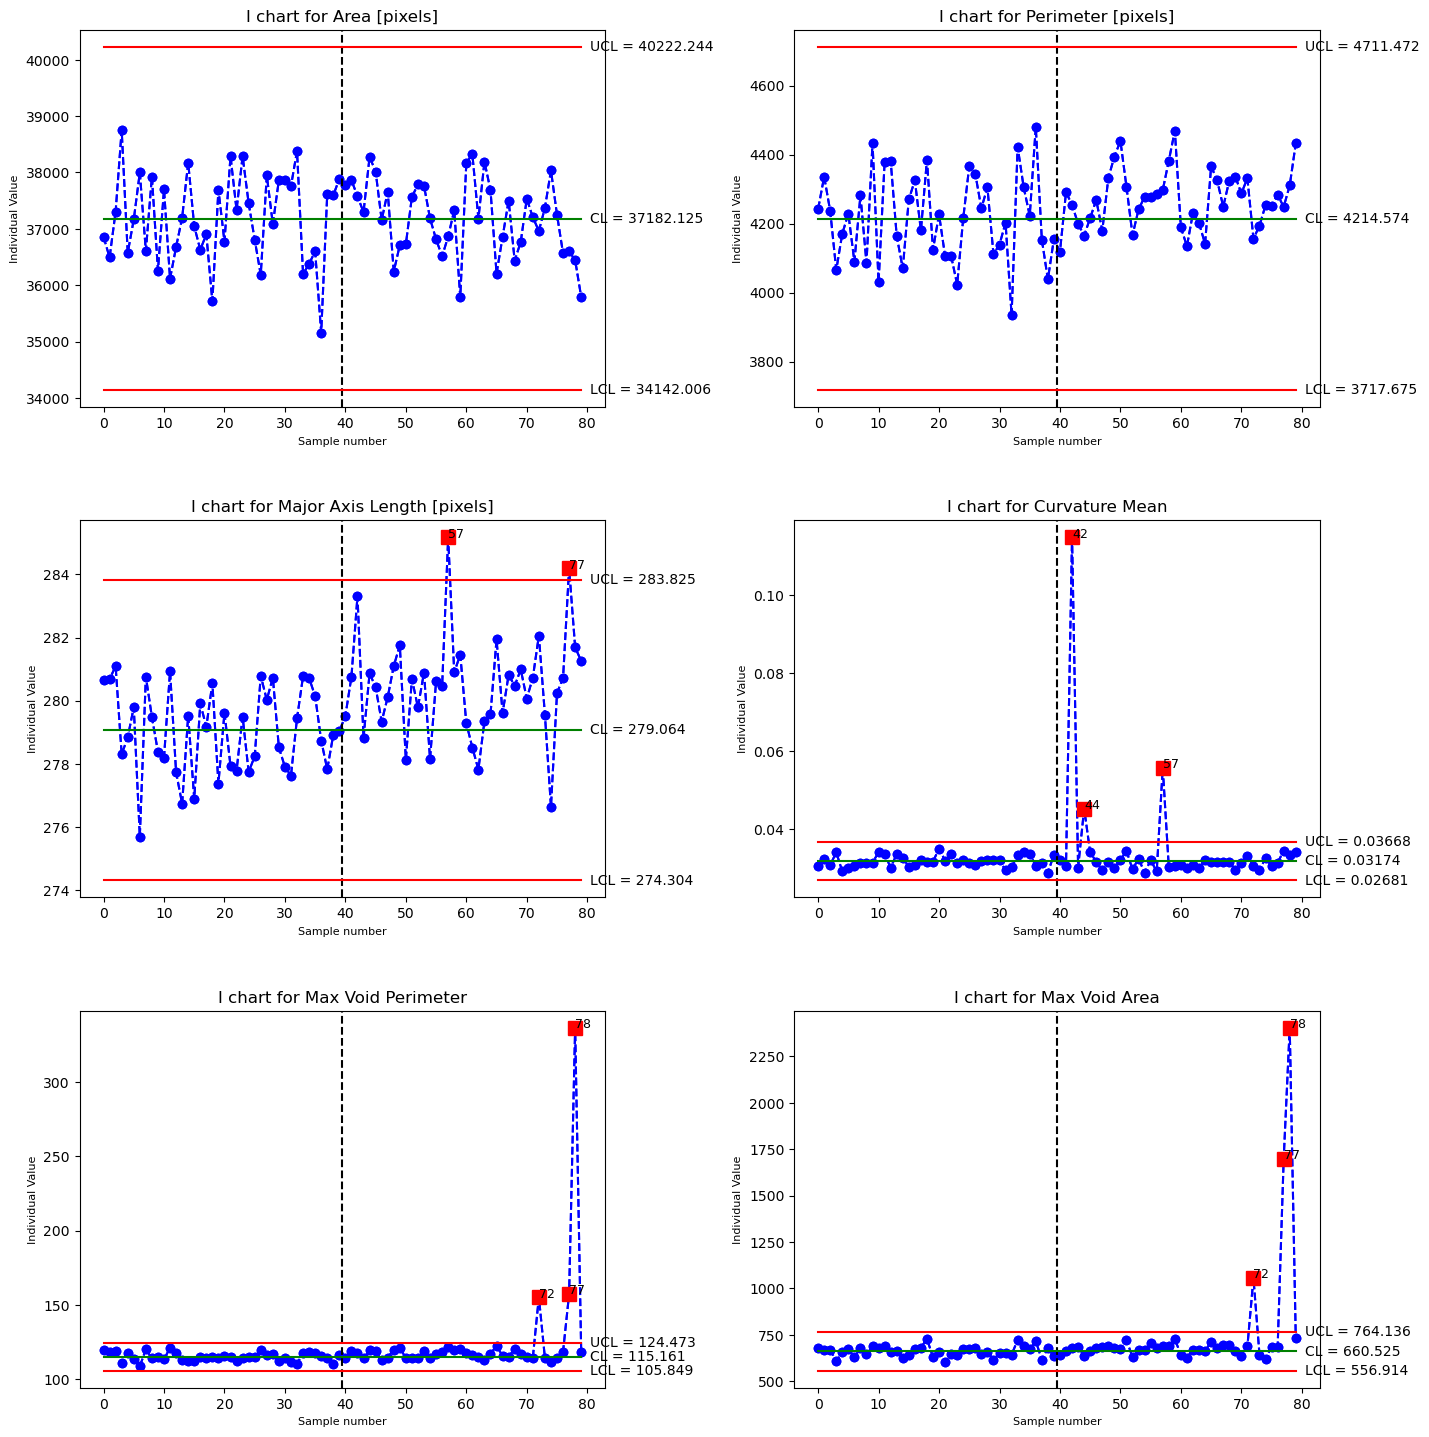

In [466]:
#### SOLVED --> IT CAN BE USED 
## or use the next code section

# manually and just the I one
d2 = 1.128
plt.figure(figsize=(16,24))
# plt.figure(figsize=(8.2, 11.69),dpi=100)
# add subplots structure
for i,chosvar in enumerate(chosen_variables,start=1):
	df = pd.DataFrame(df_shuffled[chosvar])
	df['MR'] = df[chosvar].diff().abs()
	df['I_UCL'] = df[chosvar].iloc[:40].mean() + (K_alpha*df['MR'].iloc[:40].mean()/d2)
	df['I_CL'] = df[chosvar].iloc[:40].mean()
	df['I_LCL'] = df[chosvar].iloc[:40].mean() - (K_alpha*df['MR'].iloc[:40].mean()/d2)
	df['I_TEST1'] = np.where((df[chosvar] > df['I_UCL']) | (df[chosvar] < df['I_LCL']), df[chosvar], np.nan)
	new_OOC_idx = np.where(df['I_TEST1'].notnull())[0]
	OOC_idx.extend(new_OOC_idx)
	# df.head()

	# Plot the I chart
	plt.subplot(4,2,i)
	plt.title(f'I chart for {chosvar}')
	plt.plot(df[chosvar], color='b', linestyle='--', marker='o')
	plt.plot(df[chosvar], color='b', linestyle='--', marker='o')
	plt.axvline(x = 39.5, color = 'k', linestyle='--')
	plt.plot(df['I_UCL'], color='r')
	plt.plot(df['I_CL'], color='g')
	plt.plot(df['I_LCL'], color='r')
	plt.ylabel('Individual Value',fontsize=8)
	plt.xlabel('Sample number',fontsize=8)
	# add the values of the control limits on the right side of the plot
	if chosvar == "Curvature Mean":
		plt.text(len(df)+.5, df['I_UCL'].iloc[0], 'UCL = {:.5f}'.format(df['I_UCL'].iloc[0]), verticalalignment='center')
		plt.text(len(df)+.5, df['I_CL'].iloc[0], 'CL = {:.5f}'.format(df['I_CL'].iloc[0]), verticalalignment='center')
		plt.text(len(df)+.5, df['I_LCL'].iloc[0], 'LCL = {:.5f}'.format(df['I_LCL'].iloc[0]), verticalalignment='center')
	else:
		plt.text(len(df)+.5, df['I_UCL'].iloc[0], 'UCL = {:.3f}'.format(df['I_UCL'].iloc[0]), verticalalignment='center')
		plt.text(len(df)+.5, df['I_CL'].iloc[0], 'CL = {:.3f}'.format(df['I_CL'].iloc[0]), verticalalignment='center')
		plt.text(len(df)+.5, df['I_LCL'].iloc[0], 'LCL = {:.3f}'.format(df['I_LCL'].iloc[0]), verticalalignment='center')
	# highlight the points that violate the alarm rules
	plt.plot(df['I_TEST1'], linestyle='none', marker='s', color='r', markersize=10)
	# Add text labels for OOC points
	for idx in new_OOC_idx:
		plt.text(idx, df[chosvar].iloc[idx], str(idx), color='k', fontsize=9)# ha='center', va='bottom')
	# plt.show()

plt.subplots_adjust(wspace=0.36) 
plt.subplots_adjust(hspace=0.3) 


In [467]:
OOC_idx = np.unique(OOC_idx)
print(f'The index of the OOC point are: {OOC_idx}' )

The index of the OOC point are: [42 44 57 72 77 78]


[42 44 57 72 77 78]


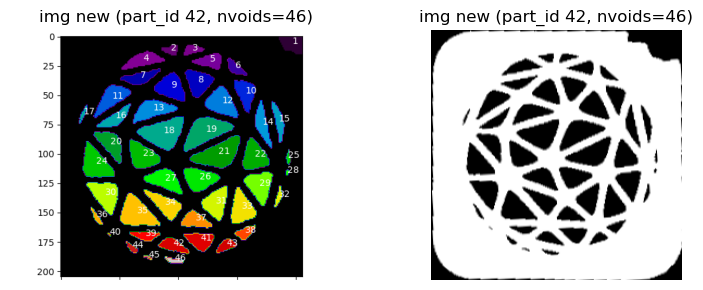

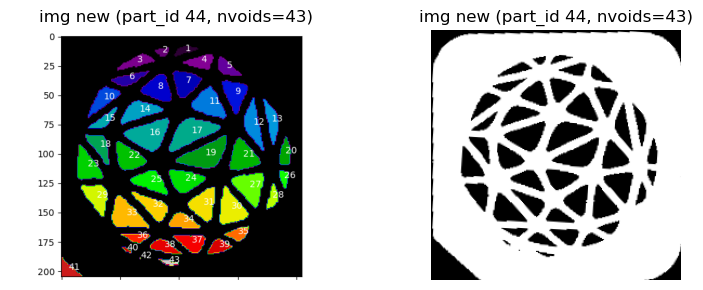

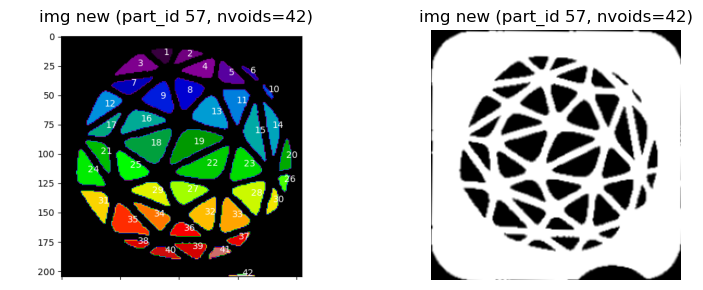

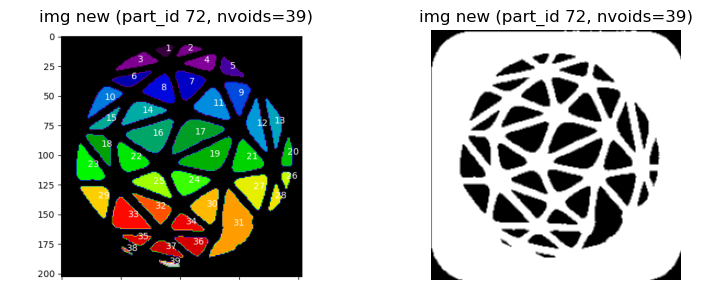

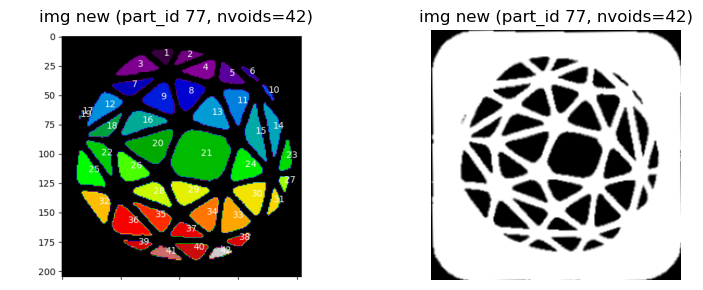

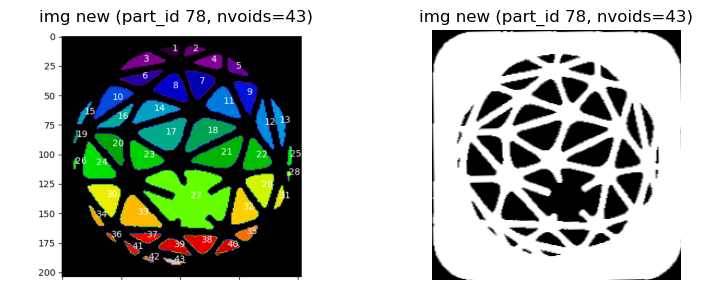

In [26]:
print(OOC_idx)
for id in OOC_idx:
	visualize_object(id)

In [27]:
ooc_idxs_set = set()

for chosvar in chosen_variables:
	# data=pd.DataFrame(df_shuffled[chosvar])
	data=pd.DataFrame(df_shuffled[chosvar])
	data_IMR = qda.ControlCharts.IMR(data,chosvar,K = K_alpha, 
								  subset_size=40,	
								#   plotit=True)
								  plotit=False)
	
	OOC_idx = np.where(data_IMR['I_TEST1'].notnull())[0]
	print(f'The index of the OOC point is: {OOC_idx} from {chosvar}')
	ooc_idxs_set.update(OOC_idx)
print(f'The index of the OOC point are: {ooc_idxs_set}' )

The index of the OOC point is: [] from Area [pixels]
The index of the OOC point is: [] from Perimeter [pixels]
The index of the OOC point is: [57 77] from Major Axis Length [pixels]
The index of the OOC point is: [42 44 57] from Curvature Mean
The index of the OOC point is: [72 77 78] from Max Void Perimeter
The index of the OOC point is: [72 77 78] from Max Void Area
The index of the OOC point are: {72, 42, 44, 77, 78, 57}


In [47]:
# print(OOC_idx)
# for id in OOC_idx:
# 	visualize_object(id)

# Multivariate CC

In [77]:
from pingouin import multivariate_normality 
multivariate_normality(data, alpha=.05) 

# data are multinormal 
# Shuffled data are multinormal 


HZResults(hz=2.9144717136458804, pval=1.346188424951265e-94, normal=False)

c:\Users\feder\anaconda3\envs\qda\lib\site-packages\outdated\utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [548]:
alpha = 0.0027 # significance level
# alpha = 0.01 # significance level
n = 1          # sample size
m = len(shuffled_first_40_rows)  # number of samples, 40
p = 6         # number of variables

In [501]:
np.outer([1, 2],[3, 4]) # example

array([[3, 4],
       [6, 8]])

### long period & original data

In [560]:
data = df_new_parts[[
'Area [pixels]',
'Perimeter [pixels]',
'Major Axis Length [pixels]',
'Curvature Mean',
'Max Void Perimeter',
'Max Void Area']]

first_40_rows=first_40_rows[[
'Area [pixels]',
'Perimeter [pixels]',
'Major Axis Length [pixels]',
'Curvature Mean',
'Max Void Perimeter',
'Max Void Area']]

In [561]:
###### long period
# Calcolo del vettore medio
Xbar = first_40_rows.mean(axis=0)
print(Xbar)

# Inizializzazione della matrice di varianza S
S = np.zeros((first_40_rows.shape[1], first_40_rows.shape[1]))

# Calcolo della matrice di varianza S
for i in range(m):
    diff = first_40_rows.iloc[i] - Xbar
    S += np.outer(diff, diff)
    # S += data.iloc[i]-Xbar.dot(data.iloc[i]-Xbar.transpose())

S /= (m - 1)

print("La matrice di varianza S è:")
print(S)

S1 = S
S1_inv = np.linalg.inv(S1)

Area [pixels]                 37182.125000
Perimeter [pixels]             4214.573575
Major Axis Length [pixels]      279.064350
Curvature Mean                    0.031744
Max Void Perimeter              115.161175
Max Void Area                   660.525000
dtype: float64
La matrice di varianza S è:
[[ 6.50745548e+05 -9.09027908e+04 -4.46412788e+02  2.92050200e-02
  -1.48045333e+03 -1.94592981e+04]
 [-9.09027908e+04  1.68346372e+04  6.33472965e+01 -4.07862860e-03
   2.46714568e+02  2.56581156e+03]
 [-4.46412788e+02  6.33472965e+01  1.85792069e+00  2.56475366e-04
   2.78543012e+00  1.93262987e+01]
 [ 2.92050200e-02 -4.07862860e-03  2.56475366e-04  2.18386919e-06
   6.76832711e-04 -9.24711236e-04]
 [-1.48045333e+03  2.46714568e+02  2.78543012e+00  6.76832711e-04
   8.68464897e+00  4.01291365e+01]
 [-1.94592981e+04  2.56581156e+03  1.93262987e+01 -9.24711236e-04
   4.01291365e+01  8.31486538e+02]]


c:\Users\feder\anaconda3\envs\qda\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == "__main__":


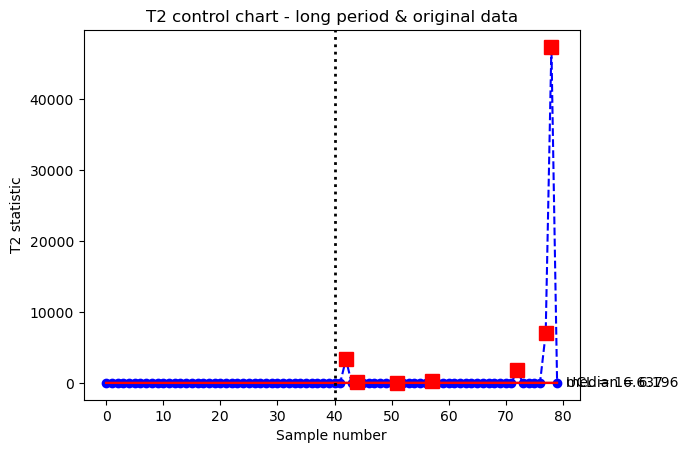

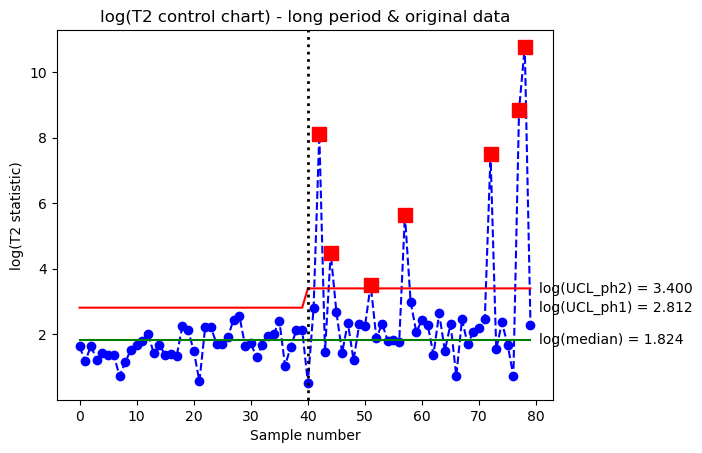

The index of the OOC point is: [42 44 51 57 72 77 78]


In [562]:
# Calculate the Hotelling T2 statistic
data_CC = data.copy()
data_CC['T2'] = np.nan
for i in range(data.shape[0]):
    data_CC['T2'].iloc[i] = n * (data.iloc[i] - Xbar).transpose().dot(S1_inv).dot(data.iloc[i] - Xbar)

# Now we can add the UCL, CL and LCL to the dataframe
data_CC['T2_UCL'] = ((m-1)**2)/m*stats.beta.ppf(1 - alpha, p/2, (m-p-1)/2) 
data_CC['T2_UCL'][40:] = (p*(m-1)*(m+1))/(m*m-m*p)*stats.f.ppf(1 - alpha, p, m-p)
# what will be the phase 2 limit?
phase2_UCL = (p*(m-1)*(m+1))/(m*m-m*p)*stats.f.ppf(1 - alpha, p, m-p)

data_CC['T2_CL'] = data_CC['T2'].median()
data_CC['T2_LCL'] = 0

# Add one column to test if the sample is out of control
#data_CC['T2_TEST'] = np.where((data_CC['T2'] > data_CC['T2_UCL']), data_CC['T2'], np.nan)
data_CC['T2_TEST'] = np.where((data_CC['T2'] > phase2_UCL), data_CC['T2'], np.nan)


# Plot the T2 control chart
plt.title('T2 control chart - long period & original data')
plt.plot(data_CC['T2'], color='b', linestyle='--', marker='o')
plt.plot(data_CC['T2_UCL'], color='r')
plt.plot(data_CC['T2_CL'], color='g')
plt.plot(data_CC['T2_LCL'], color='r')
plt.axvline(x=m, color='black', linestyle=':', linewidth=2)
plt.ylabel('T2 statistic')
plt.xlabel('Sample number')
# add the values of the control limits on the right side of the plot
plt.text(len(data_CC)+.5, data_CC['T2_UCL'].iloc[0], 'UCL = {:.3f}'.format(data_CC['T2_UCL'].iloc[0]), verticalalignment='center')
plt.text(len(data_CC)+.5, data_CC['T2_CL'].iloc[0], 'median = {:.3f}'.format(data_CC['T2_CL'].iloc[0]), verticalalignment='center')
# highlight the points that violate the alarm rules
plt.plot(data_CC['T2_TEST'], linestyle='none', marker='s', color='r', markersize=10)
plt.show()

# Plot the log T2 control chart
plt.title('log(T2 control chart) - long period & original data')
plt.plot(np.log(data_CC['T2']), color='b', linestyle='--', marker='o')
plt.plot(np.log(data_CC['T2_UCL']), color='r')
plt.plot(np.log(data_CC['T2_CL']), color='g')
plt.plot(np.log(data_CC['T2_LCL']), color='r')
plt.axvline(x=m, color='black', linestyle=':', linewidth=2)
plt.ylabel('log(T2 statistic)')
plt.xlabel('Sample number')
# add the values of the control limits on the right side of the plot
plt.text(len(data_CC)+.5, np.log(data_CC['T2_UCL']).iloc[0], 'log(UCL_ph1) = {:.3f}'.format(np.log(data_CC['T2_UCL']).iloc[0]), verticalalignment='center')
plt.text(len(data_CC)+.5, np.log(data_CC['T2_UCL']).iloc[70], 'log(UCL_ph2) = {:.3f}'.format(np.log(data_CC['T2_UCL']).iloc[70]), verticalalignment='center')
plt.text(len(data_CC)+.5, np.log(data_CC['T2_CL']).iloc[0], 'log(median) = {:.3f}'.format(np.log(data_CC['T2_CL']).iloc[0]), verticalalignment='center')
# highlight the points that violate the alarm rules
plt.plot(np.log(data_CC['T2_TEST']), linestyle='none', marker='s', color='r', markersize=10)
plt.show()

OOC_idx = np.where(data_CC['T2_TEST'].notnull())[0]
print('The index of the OOC point is: {}'.format(OOC_idx))

### short period & shuffled version 

In [563]:
data = df_shuffled[[
'Area [pixels]',
'Perimeter [pixels]',
'Major Axis Length [pixels]',
'Curvature Mean',
'Max Void Perimeter',
'Max Void Area']]

shuffled_first_40_rows=shuffled_first_40_rows[[
'Area [pixels]',
'Perimeter [pixels]',
'Major Axis Length [pixels]',
'Curvature Mean',
'Max Void Perimeter',
'Max Void Area']]

In [564]:
###### short period
# Create the V matrix
V = shuffled_first_40_rows.diff().dropna()

# Calculate the short range estimator S2
S2 = 1/2 * V.transpose().dot(V) / (m-1)
S2_inv = np.linalg.inv(S2)

# Display the short range estimator
print("The short range estimator is: \n", S2)

# Calculate the Xbar from the data
Xbar = shuffled_first_40_rows.mean()

The short range estimator is: 
                             Area [pixels]  Perimeter [pixels]  \
Area [pixels]               674714.653846       -97086.056269   
Perimeter [pixels]          -97086.056269        18904.996310   
Major Axis Length [pixels]    -441.197397           55.444769   
Curvature Mean                   0.161248           -0.020360   
Max Void Perimeter           -1412.596705          231.530203   
Max Void Area               -20223.615385         2697.983269   

                            Major Axis Length [pixels]  Curvature Mean  \
Area [pixels]                              -441.197397        0.161248   
Perimeter [pixels]                           55.444769       -0.020360   
Major Axis Length [pixels]                    1.878508        0.000148   
Curvature Mean                                0.000148        0.000002   
Max Void Perimeter                            2.524341       -0.000079   
Max Void Area                                19.153833       -0.0044

c:\Users\feder\anaconda3\envs\qda\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
c:\Users\feder\anaconda3\envs\qda\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == "__main__":


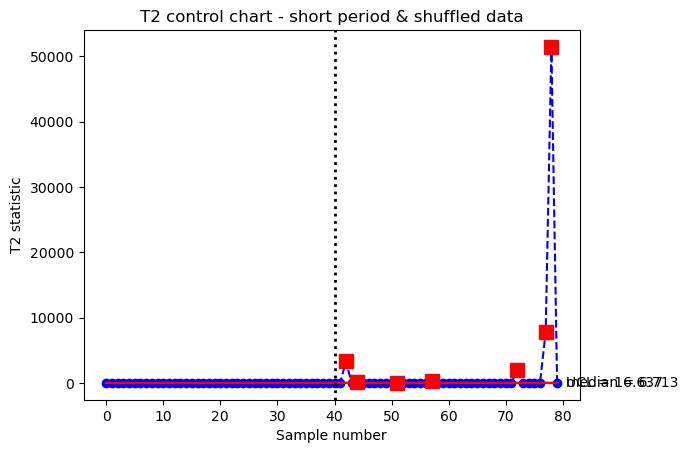

c:\Users\feder\anaconda3\envs\qda\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


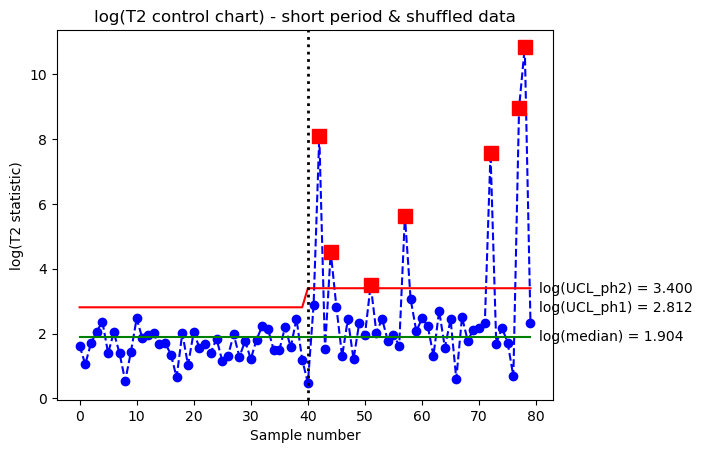

The index of the OOC point is: [42 44 51 57 72 77 78]


In [565]:
# Calculate the Hotelling T2 statistic
data_CC = data.copy()
data_CC['T2'] = np.nan
for i in range(data.shape[0]):
    data_CC['T2'].iloc[i] = n * (data.iloc[i] - Xbar).transpose().dot(S2_inv).dot(data.iloc[i] - Xbar)

# Now we can add the UCL, CL and LCL to the dataframe
data_CC['T2_UCL'] = ((m-1)**2)/m*stats.beta.ppf(1 - alpha, p/2, (m-p-1)/2) 
data_CC['T2_UCL'][40:] = (p*(m-1)*(m+1))/(m*m-m*p)*stats.f.ppf(1 - alpha, p, m-p)
# what will be the phase 2 limit?
phase2_UCL = (p*(m-1)*(m+1))/(m*m-m*p)*stats.f.ppf(1 - alpha, p, m-p)

data_CC['T2_CL'] = data_CC['T2'].median()
data_CC['T2_LCL'] = 0

# Add one column to test if the sample is out of control
data_CC['T2_TEST'] = np.where((data_CC['T2'] > data_CC['T2_UCL']), data_CC['T2'], np.nan)

# Plot the T2 control chart
plt.title('T2 control chart - short period & shuffled data')
plt.plot(data_CC['T2'], color='b', linestyle='--', marker='o')
plt.plot(data_CC['T2_UCL'], color='r')
plt.plot(data_CC['T2_CL'], color='g')
plt.plot(data_CC['T2_LCL'], color='r')
plt.axvline(x=m, color='black', linestyle=':', linewidth=2)
plt.ylabel('T2 statistic')
plt.xlabel('Sample number')
# add the values of the control limits on the right side of the plot
plt.text(len(data_CC)+.5, data_CC['T2_UCL'].iloc[0], 'UCL = {:.3f}'.format(data_CC['T2_UCL'].iloc[0]), verticalalignment='center')
plt.text(len(data_CC)+.5, data_CC['T2_CL'].iloc[0], 'median = {:.3f}'.format(data_CC['T2_CL'].iloc[0]), verticalalignment='center')
# highlight the points that violate the alarm rules
plt.plot(data_CC['T2_TEST'], linestyle='none', marker='s', color='r', markersize=10)
plt.show()


# Plot the log T2 control chart
plt.title('log(T2 control chart) - short period & shuffled data')
plt.plot(np.log(data_CC['T2']), color='b', linestyle='--', marker='o')
plt.plot(np.log(data_CC['T2_UCL']), color='r')
plt.plot(np.log(data_CC['T2_CL']), color='g')
plt.plot(np.log(data_CC['T2_LCL']), color='r')
plt.axvline(x=m, color='black', linestyle=':', linewidth=2)
plt.ylabel('log(T2 statistic)')
plt.xlabel('Sample number')
# add the values of the control limits on the right side of the plot
plt.text(len(data_CC)+.5, np.log(data_CC['T2_UCL']).iloc[0], 'log(UCL_ph1) = {:.3f}'.format(np.log(data_CC['T2_UCL']).iloc[0]), verticalalignment='center')
plt.text(len(data_CC)+.5, np.log(data_CC['T2_UCL']).iloc[70], 'log(UCL_ph2) = {:.3f}'.format(np.log(data_CC['T2_UCL']).iloc[70]), verticalalignment='center')
plt.text(len(data_CC)+.5, np.log(data_CC['T2_CL']).iloc[0], 'log(median) = {:.3f}'.format(np.log(data_CC['T2_CL']).iloc[0]), verticalalignment='center')
# highlight the points that violate the alarm rules
plt.plot(np.log(data_CC['T2_TEST']), linestyle='none', marker='s', color='r', markersize=10)
plt.show()


OOC_idx = np.where(data_CC['T2_TEST'].notnull())[0]
print('The index of the OOC point is: {}'.format(OOC_idx))

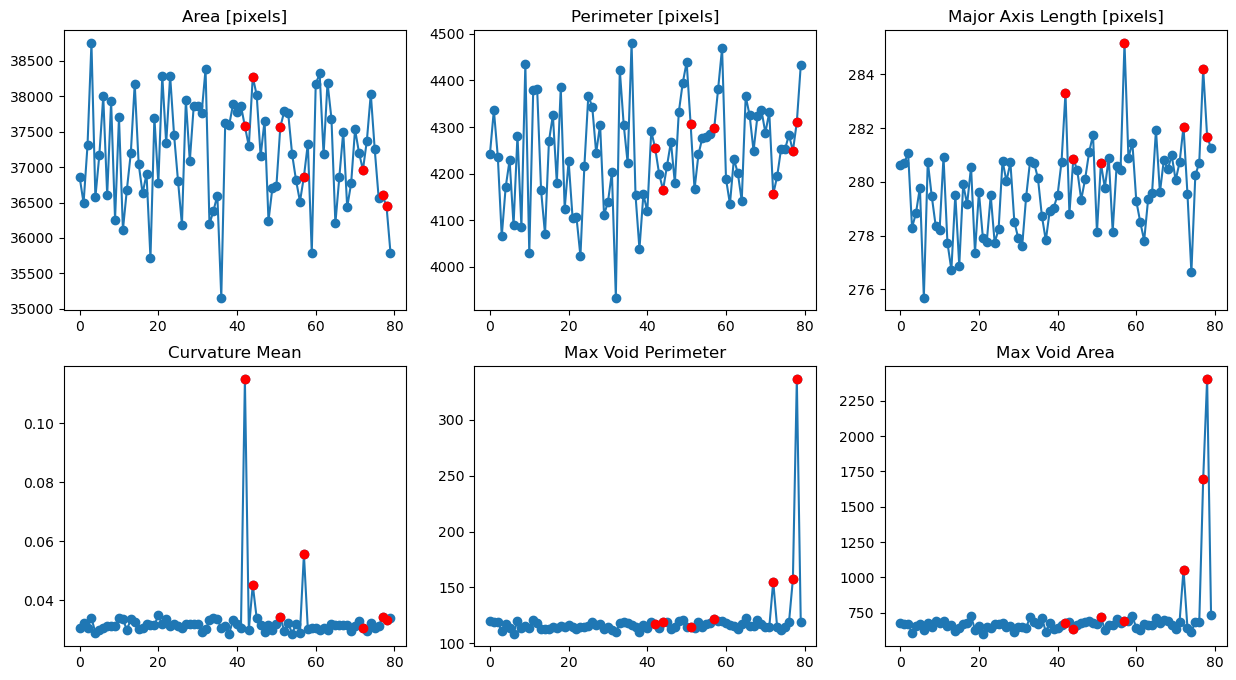

In [567]:
plt.figure(figsize=(15,8))
for idx,col in enumerate(data.columns,start=1):
	plt.subplot(2,3,idx)
	plt.plot(data[col],'o-')
	for id in OOC_idx:
		plt.plot(id, data[col].iloc[id], 'ro', markersize=6)
	plt.title(col)
	# plt.show()

Attempt using trays

In [39]:
# Break single column data in different samples
m1=20   #number of trays
n1=4    #elements per tray
trays = {}

# Loop through each column name in the DataFrame
for col in chosen_variables:
    # Create a new DataFrame with a single column
    #trays[col] = data[[col]]
    trays[col]=pd.DataFrame(np.array(data[col]).reshape(m1,n1))

In [40]:
for key, tray in trays.items():
    print(f"DataFrame for column {key}:")
    print(tray.head())
    print()

DataFrame for column Area [pixels]:
       0      1      2      3
0  36860  36493  37306  38753
1  36573  37166  38000  36607
2  37927  36260  37702  36115
3  36679  37195  38176  37046
4  36630  36903  35716  37697

DataFrame for column Perimeter [pixels]:
          0         1         2         3
0  4242.076  4336.100  4236.644  4065.490
1  4170.845  4228.946  4089.649  4281.740
2  4085.791  4434.485  4029.306  4378.568
3  4381.455  4164.070  4069.909  4269.906
4  4325.414  4180.034  4384.828  4124.720

DataFrame for column Major Axis Length [pixels]:
         0        1        2        3
0  280.642  280.687  281.087  278.299
1  278.836  279.791  275.692  280.759
2  279.482  278.375  278.190  280.931
3  277.730  276.729  279.526  276.883
4  279.910  279.169  280.557  277.368

DataFrame for column Curvature Mean:
          0         1         2         3
0  0.030571  0.032363  0.030746  0.033967
1  0.029111  0.029868  0.030571  0.031352
2  0.031352  0.031380  0.033967  0.033541
3  0.0

In [41]:
#data_stack[['Area [pixels]', 'Perimeter [pixels]', 'Major Axis Length [pixels]','Curvature Mean','Max Void Perimeter','Max Void Area']] = Cov1.transpose().melt()

#new dataframe to store stacked data
data_stack = pd.DataFrame()
data_stack[['sample', 'Area [pixels]']] = trays['Area [pixels]'].transpose().melt()
data_stack['Perimeter [pixels]'] = trays['Perimeter [pixels]'].transpose().melt()['value']
data_stack['Major Axis Length [pixels]'] = trays['Major Axis Length [pixels]'].transpose().melt()['value']
data_stack['Curvature Mean'] = trays['Curvature Mean'].transpose().melt()['value']
data_stack['Max Void Perimeter'] = trays['Max Void Perimeter'].transpose().melt()['value']
data_stack['Max Void Area'] = trays['Max Void Area'].transpose().melt()['value']

data_stack.head(10)

sample  Area [pixels]  Perimeter [pixels]  Major Axis Length [pixels]  \
0       0          36860            4242.076                     280.642   
1       0          36493            4336.100                     280.687   
2       0          37306            4236.644                     281.087   
3       0          38753            4065.490                     278.299   
4       1          36573            4170.845                     278.836   
5       1          37166            4228.946                     279.791   
6       1          38000            4089.649                     275.692   
7       1          36607            4281.740                     280.759   
8       2          37927            4085.791                     279.482   
9       2          36260            4434.485                     278.375   

   Curvature Mean  Max Void Perimeter  Max Void Area  
0        0.030571             119.740          678.0  
1        0.032363             118.569          670.0  
2        0.030746             118.811          668.0  
3        0.033967             110.912          609.0  
4        0.029111             117.397          656.0  
5        0.029868             113.740          673.0  
6        0.030571             108.669          628.0  
7        0.031352             120.225          679.0  
8        0.031352             113.983          646.0  
9        0.031380             115.154          689.0

In [42]:
#new dataframe to store sample mean
sample_mean = pd.DataFrame()

sample_mean['Area [pixels]'] = trays['Area [pixels]'].mean(axis=1)
sample_mean['Perimeter [pixels]'] = trays['Perimeter [pixels]'].mean(axis=1)
sample_mean['Major Axis Length [pixels]'] = trays['Major Axis Length [pixels]'].mean(axis=1)
sample_mean['Curvature Mean'] = trays['Curvature Mean'].mean(axis=1)
sample_mean['Max Void Perimeter'] = trays['Max Void Perimeter'].mean(axis=1)
sample_mean['Max Void Area'] = trays['Max Void Area'].mean(axis=1)

#Calculate grand mean
Xbarbar = sample_mean.mean()
print(Xbarbar)

Area [pixels]                 37191.137500
Perimeter [pixels]             4242.423925
Major Axis Length [pixels]      279.753575
Curvature Mean                    0.033044
Max Void Perimeter              119.721688
Max Void Area                   706.475000
dtype: float64


In [43]:
# Compute variance and covariance matrix of each sample
cov_matrix = data_stack.groupby('sample').cov()

# Compute mean covariance matrix
S = cov_matrix.groupby(level=1).mean()
cols = S.columns.tolist()
S = S.reindex(columns=cols, index=cols)
S_inv = np.linalg.inv(S)

In [51]:
p = 6          # number of random variables
m = 10          # number of samples
n = 4           # number of replicates (sample size)
alpha = 0.0027    # significance level

#first phase
UCL1 = (p * (m-1) * (n-1)) / (m * (n-1) - (p-1)) * stats.f.ppf(1-alpha, p, m*n - m + 1 - p)
#for second phase
UCL = (p * (m+1) * (n-1)) / (m * (n-1) - (p-1)) * stats.f.ppf(1-alpha, p, m*n - m + 1 - p)

print('UCL = %.3f' % UCL)

UCL = 36.710


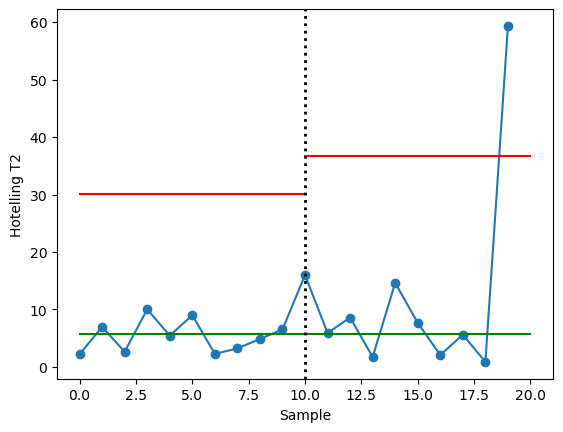

In [52]:
# Calculate Hotelling T2 statistic for all samples
T2 = []
for i in range(m*2):
    T2.append(n * (sample_mean.iloc[i]-Xbarbar).transpose().dot(S_inv).dot(sample_mean.iloc[i]-Xbarbar))

# Plot Hotelling T2 statistic
plt.plot(T2, 'o-')
plt.plot([0, m], [UCL1, UCL1], 'r-')
plt.plot([m, m*2], [UCL, UCL], 'r-')
plt.plot([0, m*2], [np.median(T2), np.median(T2)], 'g-')
plt.axvline(x=m, color='black', linestyle=':', linewidth=2)
plt.xlabel('Sample')
plt.ylabel('Hotelling T2')
plt.show()

In [ ]:
#hugging?

# References/Bibliography

For our segmentation implementation
- https://gist.github.com/jdhao/1cb4c8f6561fbdb87859ac28a84b0201
- https://stackoverflow.com/questions/11627362/how-to-straighten-a-rotated-rectangle-area-of-an-image-using-opencv-in-python

For computing the curvature
- https://en.wikipedia.org/wiki/Curvature#In_terms_of_a_general_parametrization
